In [196]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from kaggle_titanic_helpers import *
from sklearn.preprocessing import MinMaxScaler

In [118]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [119]:
# Getting spend cols
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [120]:
# These people are not in the same cabin, but in same passenger group
# Need to look at capacity of cabin sizes
train[train['PassengerId'].apply(lambda x: str(x[:4]))=='0006']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True


In [121]:
# Quick view of Transported by each variable
train.groupby('Transported').count()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
Transported,,,,,,,,,,,,,
False,4315,4217,4204,4216,4225,4226,4216,4217,4231,4221,4223,4225,4216
True,4378,4275,4272,4278,4286,4288,4274,4295,4279,4264,4287,4280,4277


In [122]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


In [123]:
train.count()

PassengerId     8693
HomePlanet      8492
CryoSleep       8476
Cabin           8494
Destination     8511
Age             8514
VIP             8490
RoomService     8512
FoodCourt       8510
ShoppingMall    8485
Spa             8510
VRDeck          8505
Name            8493
Transported     8693
dtype: int64

In [124]:
train.dropna().count()

PassengerId     6606
HomePlanet      6606
CryoSleep       6606
Cabin           6606
Destination     6606
Age             6606
VIP             6606
RoomService     6606
FoodCourt       6606
ShoppingMall    6606
Spa             6606
VRDeck          6606
Name            6606
Transported     6606
dtype: int64

In [125]:
# Checking Null Values
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [126]:
def basic_prep(df):
    df[['deck', 'number', 'side']] = pd.DataFrame(
        df.Cabin.apply(lambda x: str(x).split('/')).tolist(),
        index= df.index,
        columns=['deck', 'number', 'side'],
    )
    # PassengerId follows XXXX_XX structure for all
    df['passenger_group'] = df['PassengerId'].apply(lambda x: str(x[:4]))
    df['num_group'] = df['PassengerId'].apply(lambda x: x[-2:])
    
    df['total_spend'] = df[spend_cols].sum(axis=1)
    df = df.join(df.groupby('passenger_group')\
                   .agg({'total_spend':'sum','num_group':'max'}),on='passenger_group',rsuffix='_max')
    df['num_group_max'] = df['num_group_max'].astype('int')
    
    df['surname'] = df[df['Name'].notna()].Name.apply(lambda x: str(x).split(" ")[-1])
    
    df.replace({'nan':np.nan},inplace=True) # Needed, since split above creates "nan"
    df.number = df.number.astype(float)


    # Setting up error handling as test_df doesn't have "Transported"
    try:
        df["Transported"] = df["Transported"].replace({True: 1, False: 0})
    except:
        pass
    return df

In [127]:
def fill_missing_basic(df, float_cols, object_cols):
    df[spend_cols] = df[spend_cols].fillna(df[spend_cols].mean())
    df[float_cols] = df[float_cols].fillna(df[float_cols].mean().to_dict())
    object_dict = {k:v[0] for k, v in df[object_cols].mode().to_dict().items()}
    df[object_cols] = df[object_cols].fillna(object_dict)
    return df

In [128]:
train_df = basic_prep(train)
test_df = basic_prep(test)

In [129]:
train_df = fill_cryosleep(train_df)

217 Initially
98 After Step 1: Spending Money = No CryoSleep
61 After Step 2: 1 Passenger / Zero Spend = CryoSleep
43 After Step 3: Total Group Spend Zero = CryoSleep
0 After Step 4: Total Group Spend > Zero = No CryoSleep


In [130]:
test_df = fill_cryosleep(test_df)

93 Initially
38 After Step 1: Spending Money = No CryoSleep
23 After Step 2: 1 Passenger / Zero Spend = CryoSleep
16 After Step 3: Total Group Spend Zero = CryoSleep
0 After Step 4: Total Group Spend > Zero = No CryoSleep


In [131]:
train_df = fill_homeplanet(train_df)

201 Initially
111 after filling passenger groups
104 after filling Europa decks
63 after filling Earth decks
0 after filling the rest with Earth


In [132]:
test_df = fill_homeplanet(test_df)

87 Initially
46 after filling passenger groups
40 after filling Europa decks
31 after filling Earth decks
0 after filling the rest with Earth


In [133]:
float_cols = list(train.dtypes[train.dtypes==float].index)
object_cols = list(train.dtypes[train.dtypes==object].index)

In [135]:
drop_cols = ['Name', 'PassengerId', 'Cabin']
# change_cols = ['VIP', 'CryoSleep']
for i in drop_cols:
    object_cols.remove(i)

In [136]:
train_df = fill_missing_basic(train_df, float_cols, object_cols)

test_df = fill_missing_basic(test_df, float_cols, object_cols)

In [137]:
train_df.isnull().sum()

PassengerId          0
HomePlanet           0
CryoSleep            0
Cabin              199
Destination          0
Age                  0
VIP                  0
RoomService          0
FoodCourt            0
ShoppingMall         0
Spa                  0
VRDeck               0
Name               200
Transported          0
deck                 0
number               0
side                 0
passenger_group      0
num_group            0
total_spend          0
total_spend_max      0
num_group_max        0
surname            200
dtype: int64

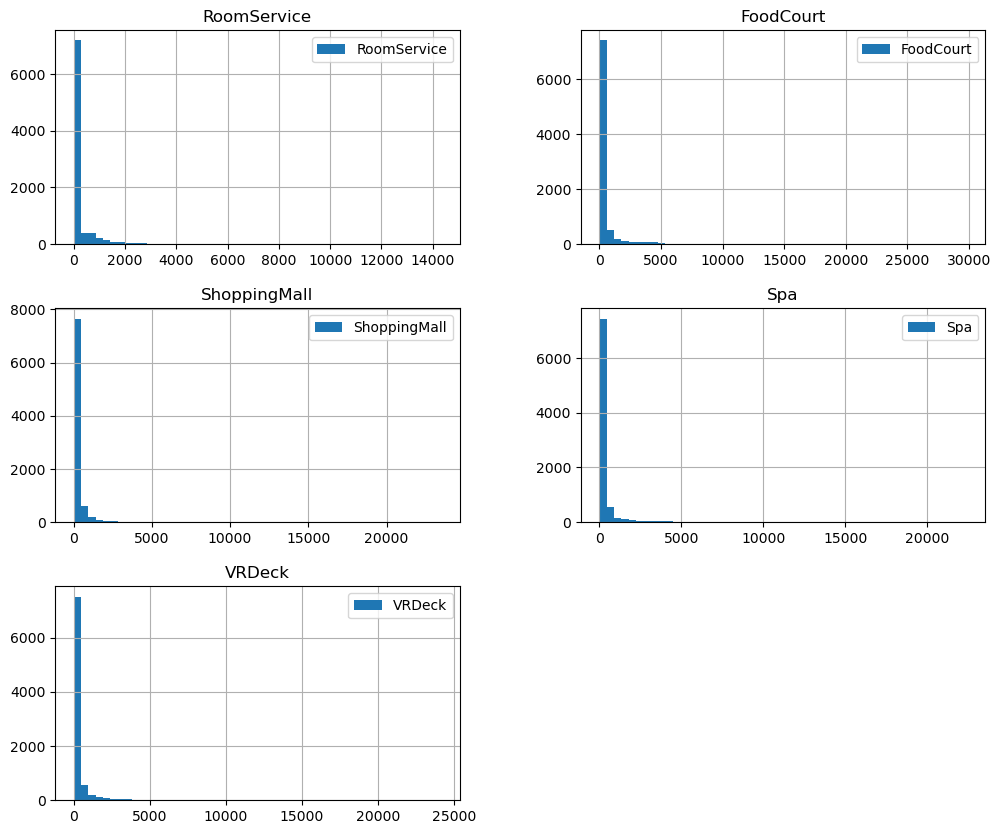

In [138]:
# Histograms for numeric variables - not normal, but mostly zero
train_df[spend_cols].hist(bins=50, figsize=(12, 10), legend=True)

plt.show()

Text(0.5, 0, 'Age (years)')

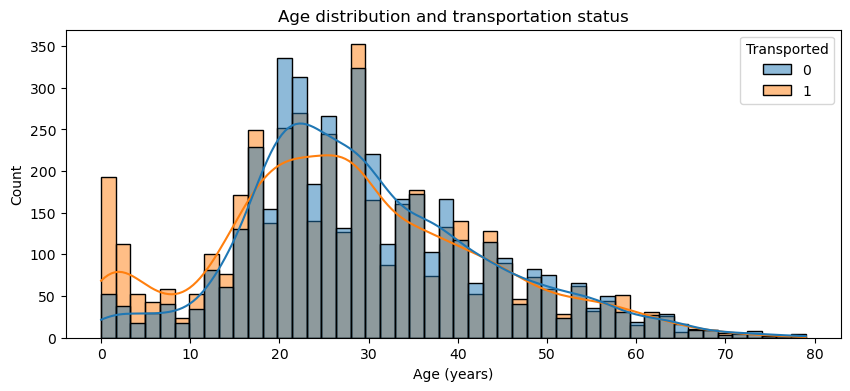

In [139]:
# Pretty similar distribution of transported versus not, used for binning
plt.figure(figsize=(10,4))

sns.histplot(train_df, x=train_df["Age"], hue="Transported", kde=True)

# Aesthetics
plt.title("Age distribution and transportation status")
plt.xlabel("Age (years)")

/var/folders/v3/vbktqv9j0y702tbl5spn92b80000gn/T/ipykernel_2374/3121090753.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_df.corr()


<Axes: >

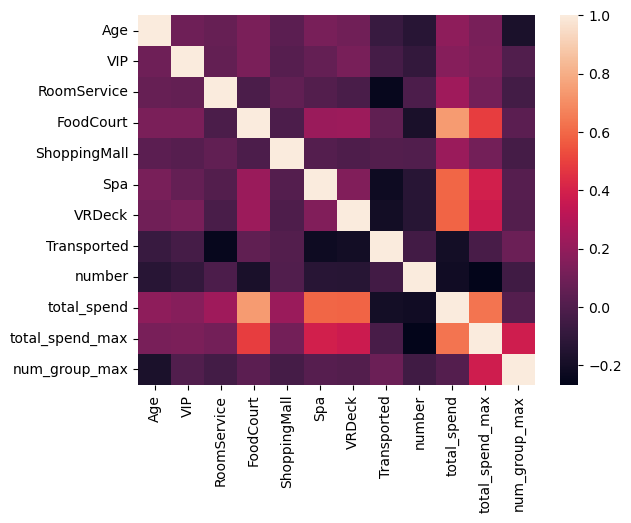

In [140]:
# Looking at data across all dimensions
corr = train_df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

Text(0.5, 0, 'Count of Passengers')

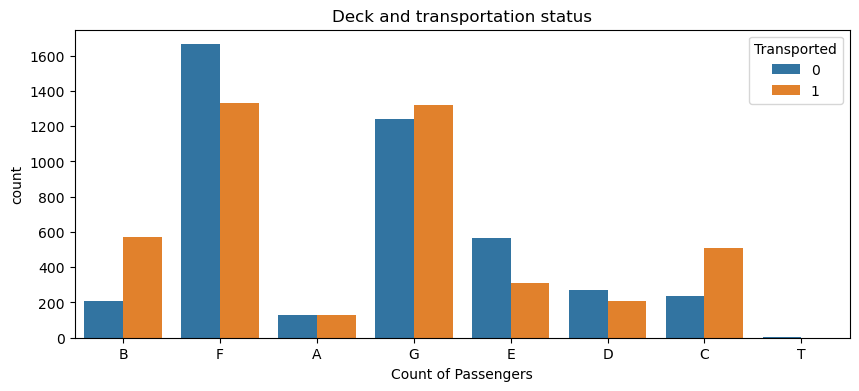

In [141]:
# Not a terrible signal...
plt.figure(figsize=(10,4))

sns.countplot(data=train_df, x="deck", hue="Transported")

# Aesthetics
plt.title("Deck and transportation status")
plt.xlabel("Count of Passengers")

Text(0.5, 0, 'Count of Passengers')

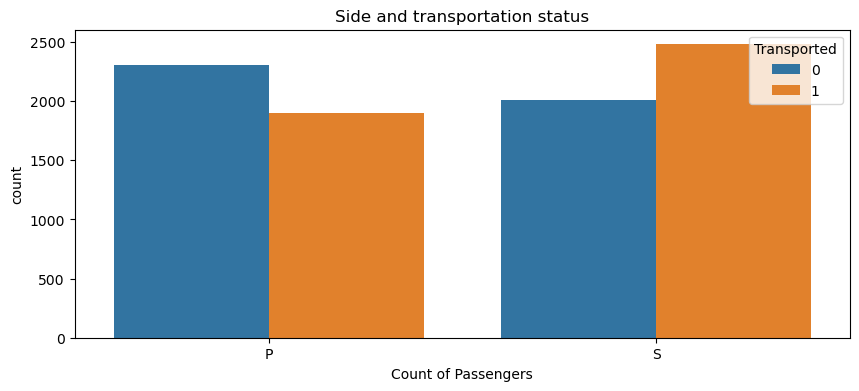

In [142]:
# Not a terrible signal...
plt.figure(figsize=(10,4))

sns.countplot(data=train_df, x="side", hue="Transported")

# Aesthetics
plt.title("Side and transportation status")
plt.xlabel("Count of Passengers")

<function matplotlib.pyplot.show(close=None, block=None)>

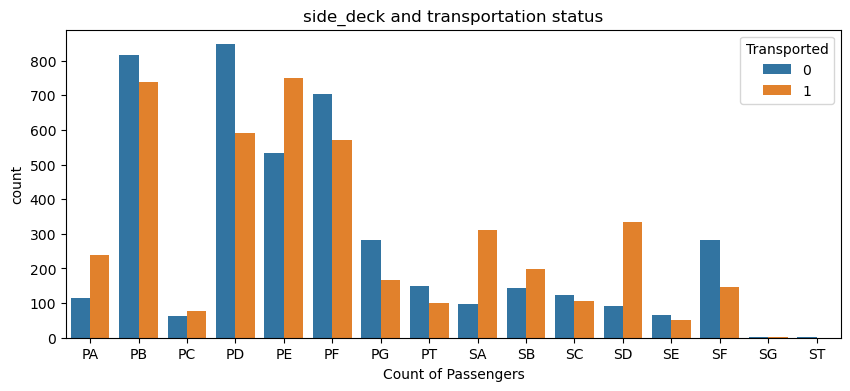

In [143]:
train_df['side_deck'] = train_df['side'] + train_df['deck']

plt.figure(figsize=(10,4))

sns.countplot(data=train_df, x="side_deck", hue="Transported")

# Aesthetics
plt.title("side_deck and transportation status")
plt.xlabel("Count of Passengers")
plt.xticks(range(len(train_df['side_deck'].sort_values().unique())),train_df['side_deck'].sort_values().unique())
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

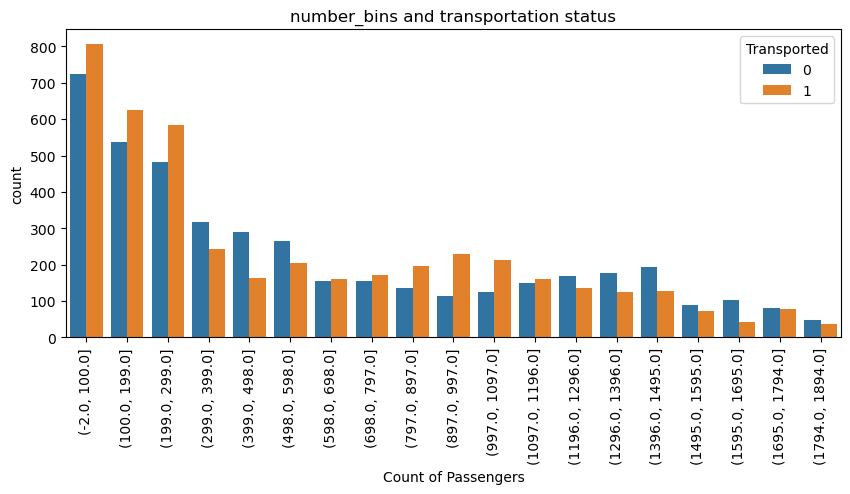

In [144]:
# Looking into issues with deck nan
# train.number.min() --0
# train.number.max() --1894

train_df['number_bins'] = pd.cut(train_df.number,19,precision=0)

plt.figure(figsize=(10,4))

sns.countplot(data=train_df, x="number_bins", hue="Transported")

# Aesthetics
plt.title("number_bins and transportation status")
plt.xlabel("Count of Passengers")
plt.xticks(range(len(train_df['number_bins'].sort_values().unique())),train_df['number_bins'].sort_values().unique(),\
          rotation=90)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

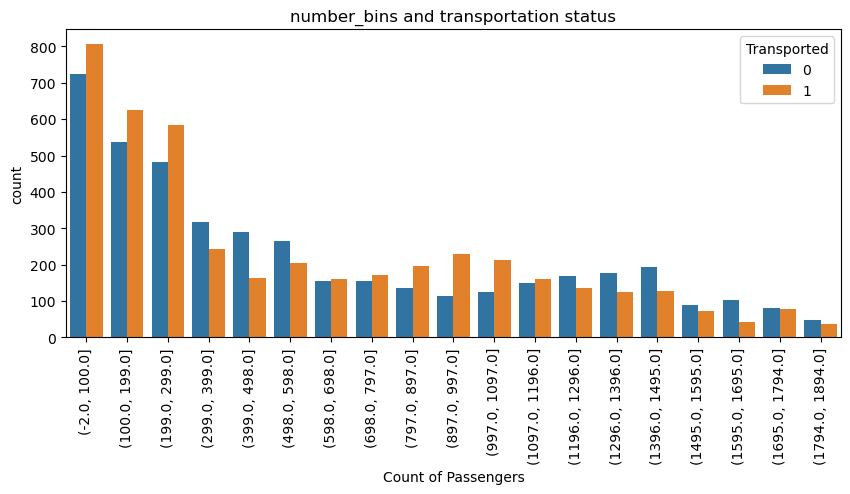

In [145]:
# Looking into issues with deck nan
# train.number.min() --0
# train.number.max() --1894

train_df['number_bins'] = pd.cut(train_df.number,19,precision=0)

plt.figure(figsize=(10,4))

sns.countplot(data=train_df, x="number_bins", hue="Transported")

# Aesthetics
plt.title("number_bins and transportation status")
plt.xlabel("Count of Passengers")
plt.xticks(range(len(train_df['number_bins'].sort_values().unique())),train_df['number_bins'].sort_values().unique(),\
          rotation=90)
plt.show

In [147]:
# For research
# train_df.dropna().groupby(['passenger_group','HomePlanet','CryoSleep','Destination','VIP','deck','side','number'])\
#                         .count()[['PassengerId']]\
#                         .sort_values(by='PassengerId').to_csv('checking_unique_passenger_group.csv')


In [148]:
# For research
# passenger_group_df = train_df.groupby(by='passenger_group').agg({'Transported':[sum,'count']})\
#                     .droplevel(level=0,axis=1).reset_index()
# passenger_group_df['% Trans'] = passenger_group_df['sum'] / passenger_group_df['count']

# passenger_group_df

,passenger_group,sum,count,% Trans
0,0001,0,1,0.000000
1,0002,1,1,1.000000
2,0003,0,2,0.000000
3,0004,1,1,1.000000
4,0005,1,1,1.000000
...,...,...,...,...
6212,9275,2,3,0.666667
6213,9276,0,1,0.000000
6214,9278,0,1,0.000000
6215,9279,1,1,1.000000


Text(0.5, 0, 'Count of Passengers')

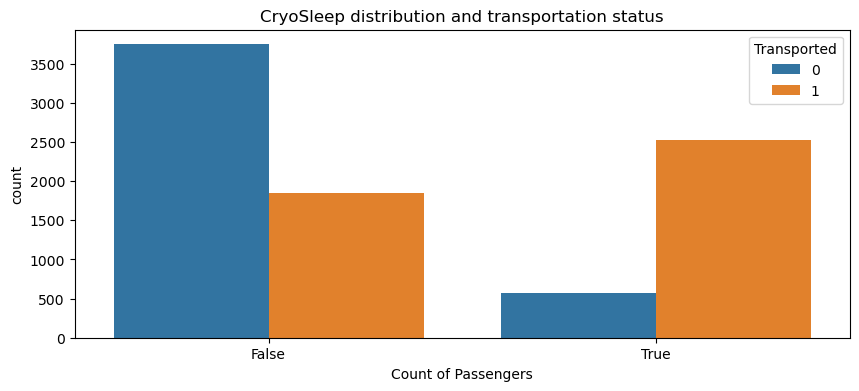

In [149]:
# Not a terrible signal...
plt.figure(figsize=(10,4))

sns.countplot(data=train_df, x="CryoSleep", hue="Transported")

# Aesthetics
plt.title("CryoSleep distribution and transportation status")
plt.xlabel("Count of Passengers")

Text(0.5, 0, 'Count of Passengers')

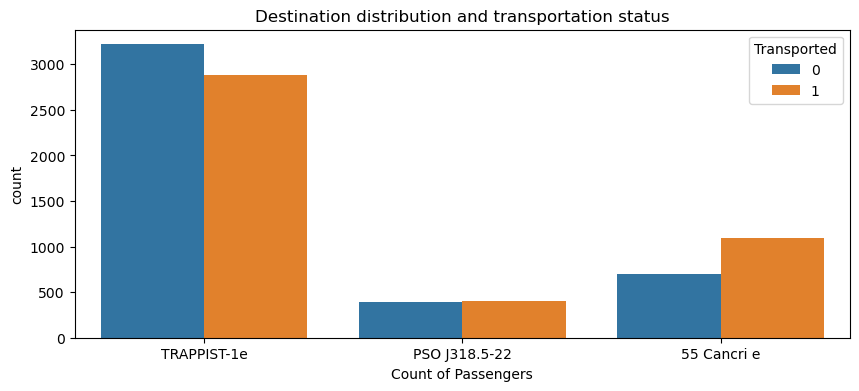

In [150]:
# Indifferent
plt.figure(figsize=(10,4))

sns.countplot(data=train_df, x="Destination", hue="Transported")

# Aesthetics
plt.title("Destination distribution and transportation status")
plt.xlabel("Count of Passengers")

Text(0.5, 0, 'Count of Passengers')

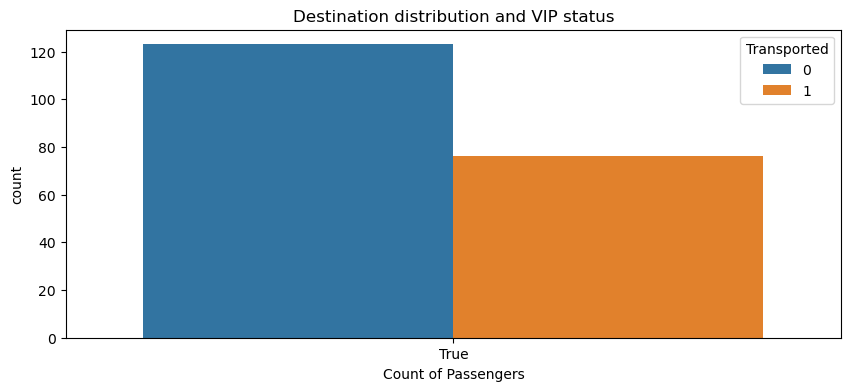

In [151]:
# Not enough people with VIP to matter
plt.figure(figsize=(10,4))

sns.countplot(data=train_df[train_df['VIP']==True], x="VIP", hue="Transported")

# Aesthetics
plt.title("Destination distribution and VIP status")
plt.xlabel("Count of Passengers")

Text(0.5, 0, 'Count of Passengers')

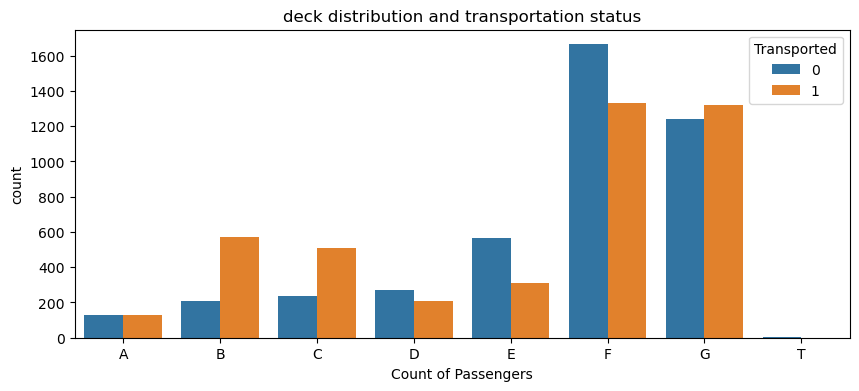

In [152]:
# Inspecting Cabin Feature Engineering....deck and cabin_type (made up names) could be good variables
plt.figure(figsize=(10,4))

sns.countplot(data=train_df.sort_values(by='deck'), x="deck", hue="Transported")

# Aesthetics
plt.title("deck distribution and transportation status")
plt.xlabel("Count of Passengers")

Text(0.5, 0, 'Count of Passengers')

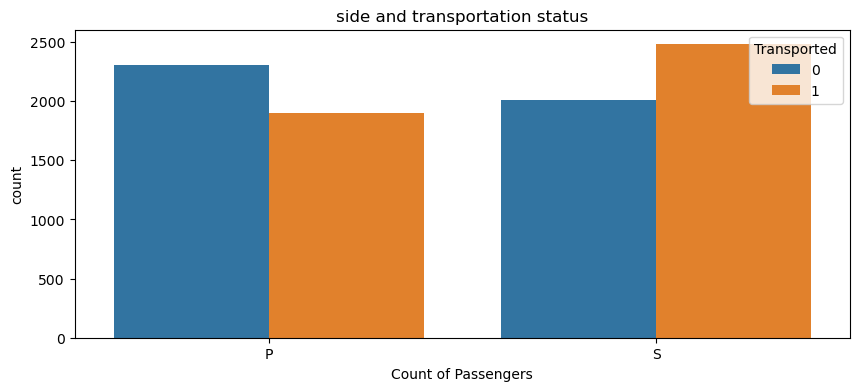

In [293]:
# Inspecting Cabin Feature Engineering....deck and cabin_type (made up names) could be good variables
plt.figure(figsize=(10,4))

sns.countplot(data=train_df, x="side", hue="Transported")

# Aesthetics
plt.title("side and transportation status")
plt.xlabel("Count of Passengers")

In [298]:
train_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,number,side,passenger_group,num_group,total_spend,total_spend_max,num_group_max,surname,side_deck,number_bins
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,P,0001,01,0.0,0.0,1,Ofracculy,PB,"(-2.0, 100.0]"
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,0.0,S,0002,01,736.0,736.0,1,Vines,SF,"(-2.0, 100.0]"
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,0.0,S,0003,01,10383.0,15559.0,2,Susent,SA,"(-2.0, 100.0]"
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,0.0,S,0003,02,5176.0,15559.0,2,Susent,SA,"(-2.0, 100.0]"
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,1.0,S,0004,01,1091.0,1091.0,1,Santantines,SF,"(-2.0, 100.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,...,98.0,P,9276,01,8536.0,8536.0,1,Noxnuther,PA,"(-2.0, 100.0]"
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,...,1499.0,S,9278,01,0.0,0.0,1,Mondalley,SG,"(1495.0, 1595.0]"
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,...,1500.0,S,9279,01,1873.0,1873.0,1,Connon,SG,"(1495.0, 1595.0]"
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,...,608.0,S,9280,01,4637.0,9463.0,2,Hontichre,SE,"(598.0, 698.0]"


In [310]:
trans_grouped = train_df.groupby('passenger_group').agg({'Transported':'mean','num_group_max':'median'}).reset_index()

trans_grouped[trans_grouped['num_group_max']!=1].groupby('Transported').count()



,passenger_group,num_group_max
Transported,,
0.000000,237,237
0.125000,2,2
0.142857,1,1
0.166667,4,4
0.200000,7,7
0.250000,16,16
0.285714,4,4
0.333333,98,98
0.375000,5,5


## Using Catboost Algo

In [154]:
from catboost import CatBoostClassifier, Pool

In [245]:
model = CatBoostClassifier(verbose=False)

In [246]:
object_cols.remove('num_group')
object_cols.remove('number')
object_cols

ValueError: list.remove(x): x not in list

In [247]:
train_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,number,side,passenger_group,num_group,total_spend,total_spend_max,num_group_max,surname,side_deck,number_bins
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,P,0001,01,0.0,0.0,1,Ofracculy,PB,"(-2.0, 100.0]"
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,0.0,S,0002,01,736.0,736.0,1,Vines,SF,"(-2.0, 100.0]"
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,0.0,S,0003,01,10383.0,15559.0,2,Susent,SA,"(-2.0, 100.0]"
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,0.0,S,0003,02,5176.0,15559.0,2,Susent,SA,"(-2.0, 100.0]"
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,1.0,S,0004,01,1091.0,1091.0,1,Santantines,SF,"(-2.0, 100.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,...,98.0,P,9276,01,8536.0,8536.0,1,Noxnuther,PA,"(-2.0, 100.0]"
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,...,1499.0,S,9278,01,0.0,0.0,1,Mondalley,SG,"(1495.0, 1595.0]"
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,...,1500.0,S,9279,01,1873.0,1873.0,1,Connon,SG,"(1495.0, 1595.0]"
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,...,608.0,S,9280,01,4637.0,9463.0,2,Hontichre,SE,"(598.0, 698.0]"


In [248]:
# Creating Train/Test splits

#Split in 75% train and 25% test set
train_df2, val_df = train_test_split(train_df, test_size = 0.25, random_state= 1984)

X_train = train_df2[object_cols+spend_cols]
y_train = train_df2.Transported

X_val = val_df[object_cols+spend_cols]
y_val = val_df.Transported

In [249]:
# Add cat_features to fit
model.fit(
        X_train
        ,y_train
        ,cat_features=object_cols
        ,plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [253]:
model.predict(X_val)


array([1, 1, 0, ..., 1, 1, 0])

## Model Validation

In [255]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

pred2 = model.predict(X_val)

# print accuracy
print("Accuracy: ", accuracy_score(y_val, pred2))

# print precision, recall, F1-score per each class/tag
print(classification_report(y_val, pred2))

# print confusion matrix, check documentation for sorting rows/columns
print(confusion_matrix(y_val, pred2))

Accuracy:  0.8040478380864765
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1090
           1       0.79      0.83      0.81      1084

    accuracy                           0.80      2174
   macro avg       0.81      0.80      0.80      2174
weighted avg       0.81      0.80      0.80      2174

[[846 244]
 [182 902]]


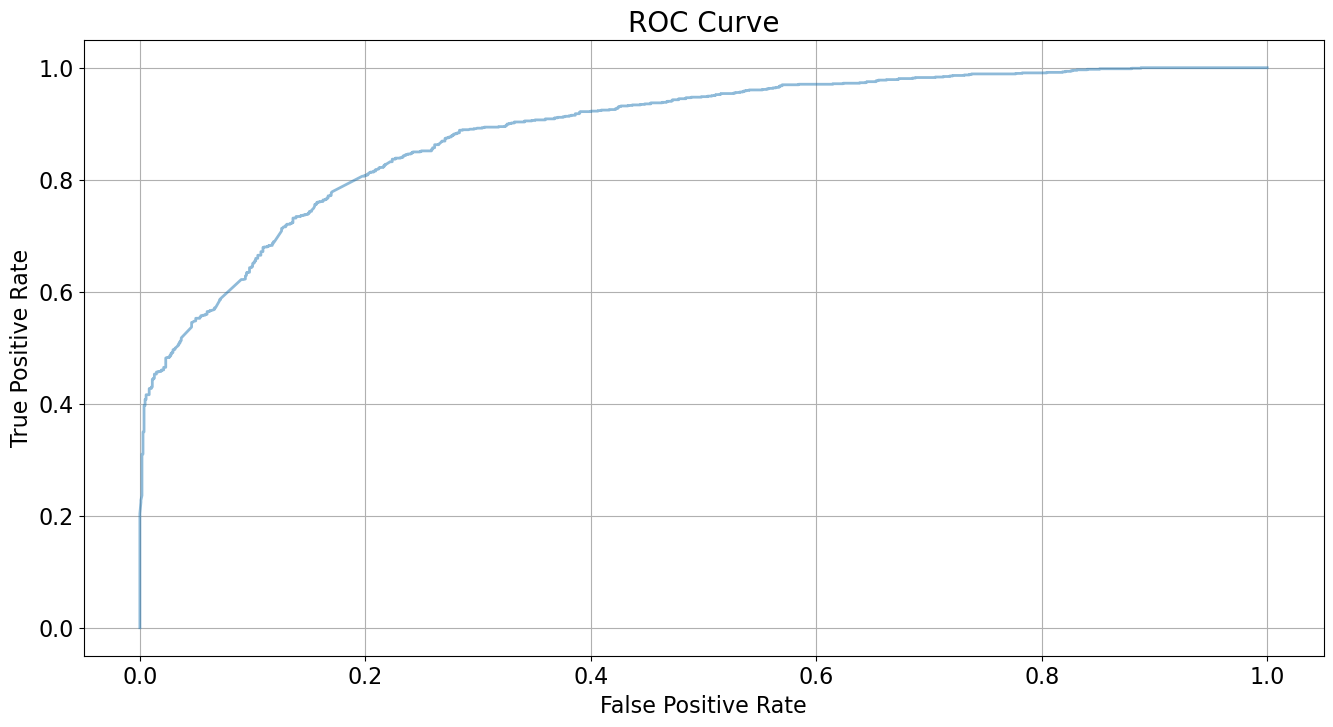

(array([0.        , 0.        , 0.        , ..., 0.99816514, 0.99908257,
        1.        ]),
 array([0.00000000e+00, 9.22509225e-04, 1.84501845e-03, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([1.00000000e+00, 9.99348783e-01, 9.98981572e-01, ...,
        4.22785330e-04, 3.46945713e-04, 0.00000000e+00]))

In [204]:
from catboost.utils import get_roc_curve

catboost_pool = Pool(X_val, y_val ,cat_features=object_cols)

get_roc_curve(model, 
              catboost_pool,
              thread_count=-1,
              plot=True)

<Figure size 700x700 with 0 Axes>

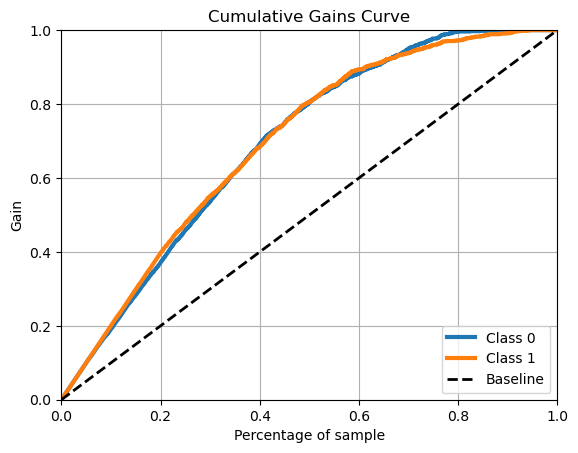

In [256]:
## Gain

import scikitplot as skplt

pred_prob2 = model.predict_proba(X_val)

plt.figure(figsize=(7,7))
skplt.metrics.plot_cumulative_gain(y_val, pred_prob2)
plt.show()

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

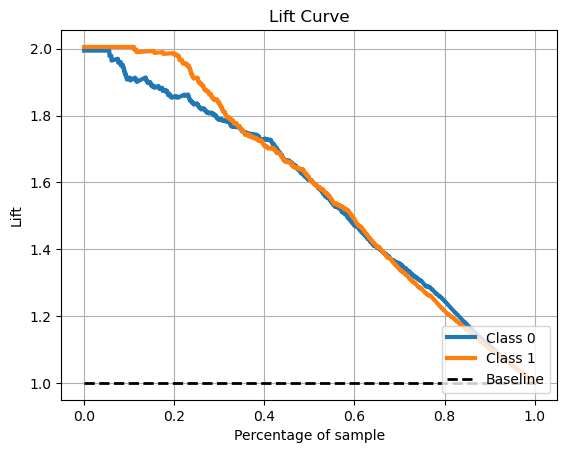

In [257]:
# Lift
skplt.metrics.plot_lift_curve(y_val, pred_prob2)

In [313]:
X_train.index

Int64Index([1715, 5494, 4763, 4014, 8274, 8343, 7037, 3991, 5353, 2573,
            ...
            5249, 2709, 4782, 8330, 3848, 7846, 5192, 1779, 5887, 4316],
           dtype='int64', length=6519)

In [314]:
y_train.index

Int64Index([1715, 5494, 4763, 4014, 8274, 8343, 7037, 3991, 5353, 2573,
            ...
            5249, 2709, 4782, 8330, 3848, 7846, 5192, 1779, 5887, 4316],
           dtype='int64', length=6519)

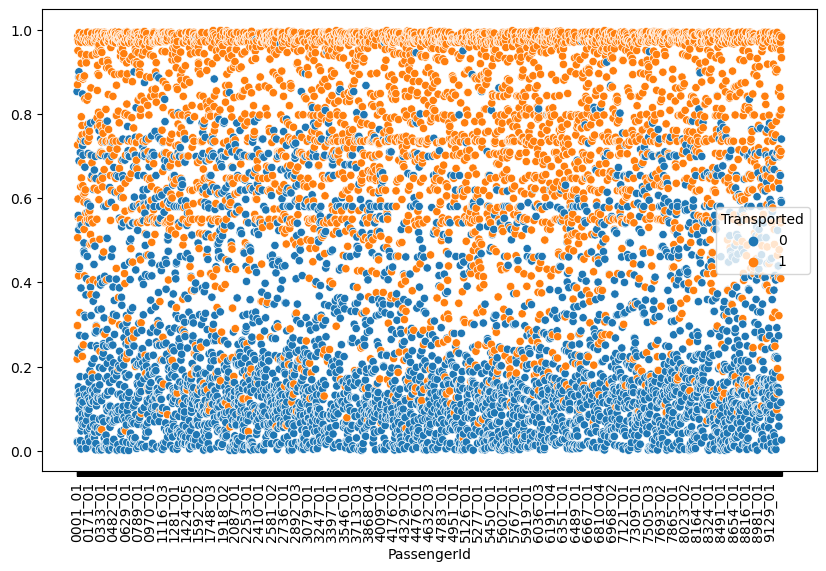

In [323]:
plt.figure(figsize=(10,6))

X = train_df.PassengerId
Y = [item[1] for item in model.predict_proba(train_df_final, 
              ntree_start=0, 
              ntree_end=0, 
              thread_count=-1, 
              verbose=None)]

plot_ = sns.scatterplot(x=X,y=Y,hue=train_df.Transported)

for ind, label in enumerate(plot_.get_xticklabels()):
    if ind % 150 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

plt.xticks(rotation=90)
plt.show()

In [286]:
train_preds_df = pd.DataFrame(zip(X,Y,train_df.Transported),columns=['PassengerId','Pred Proba','Transported'])
train_preds_df['group_size'] = train_preds_df.PassengerId.apply(lambda x : int(x[-2:]))

train_preds_df.head()

,PassengerId,Pred Proba,Transported,group_size
0,0001_01,0.854087,0,1
1,0002_01,0.217777,1,1
2,0003_01,0.022158,0,1
3,0003_02,0.020079,0,2
4,0004_01,0.296467,1,1


In [289]:
train_preds_df.groupby('group_size').mean()

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,Pred Proba,Transported
group_size,,
1,0.485345,0.475953
2,0.563362,0.558782
3,0.583509,0.618214
4,0.574000,0.593074
5,0.570713,0.546875
6,0.519480,0.546667
7,0.482040,0.500000
8,0.454956,0.461538


In [291]:
train_preds_df[(train_preds_df['Pred Proba']>.55)&(train_preds_df['Transported']==0)].groupby('group_size').mean()

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,Pred Proba,Transported
group_size,,
1,0.677253,0.0
2,0.670176,0.0
3,0.663483,0.0
4,0.712485,0.0
5,0.664812,0.0
6,0.614453,0.0
7,0.646301,0.0
8,0.655907,0.0


In [276]:
train_preds_df[(train_preds_df['Pred Proba']>.55)&(train_preds_df['Transported']==0)]\
                .sort_values(by='Pred Proba',ascending=False)

,PassengerId,Pred Proba,Transported
1475,1564_01,0.979920,0
3271,3515_01,0.978109,0
2210,2366_01,0.978109,0
5710,6048_01,0.976866,0
7286,7790_01,0.975380,0
...,...,...,...
1032,1099_01,0.552629,0
6599,6968_01,0.552421,0
8558,9137_01,0.551199,0
3771,4030_03,0.551125,0


In [277]:
check_pass_group(train,'1564')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,number,side,passenger_group,num_group,total_spend
1475,1564_01,Mars,True,F/303/S,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,Weers Merie,False,F,303,S,1564,01,0.0


In [219]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


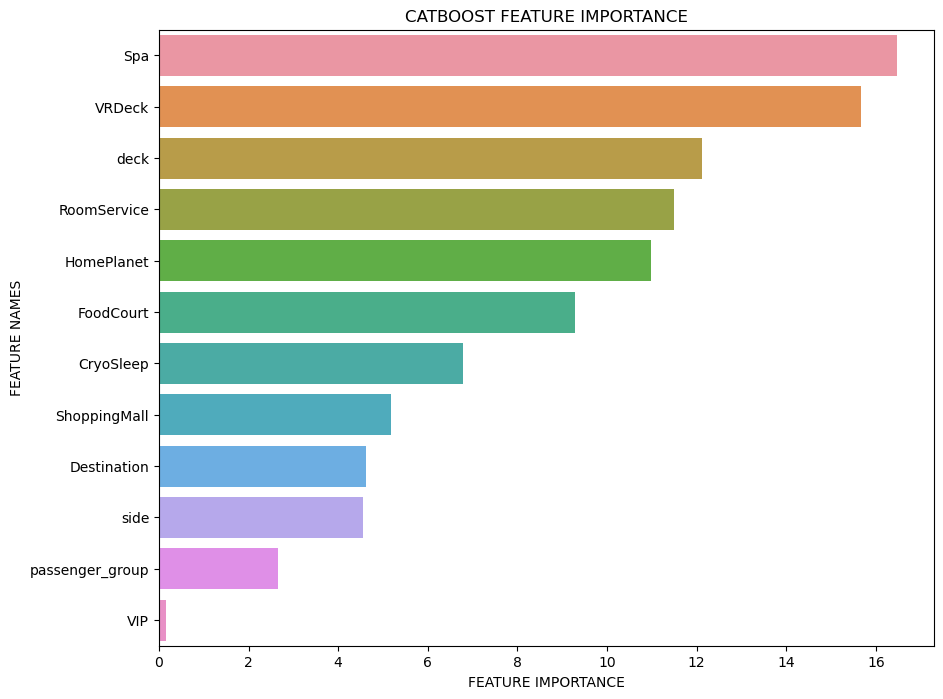

In [220]:
plot_feature_importance(model.get_feature_importance(),X_train.columns,'CATBOOST')

Text(0.5, 1.0, 'Feature Importance')

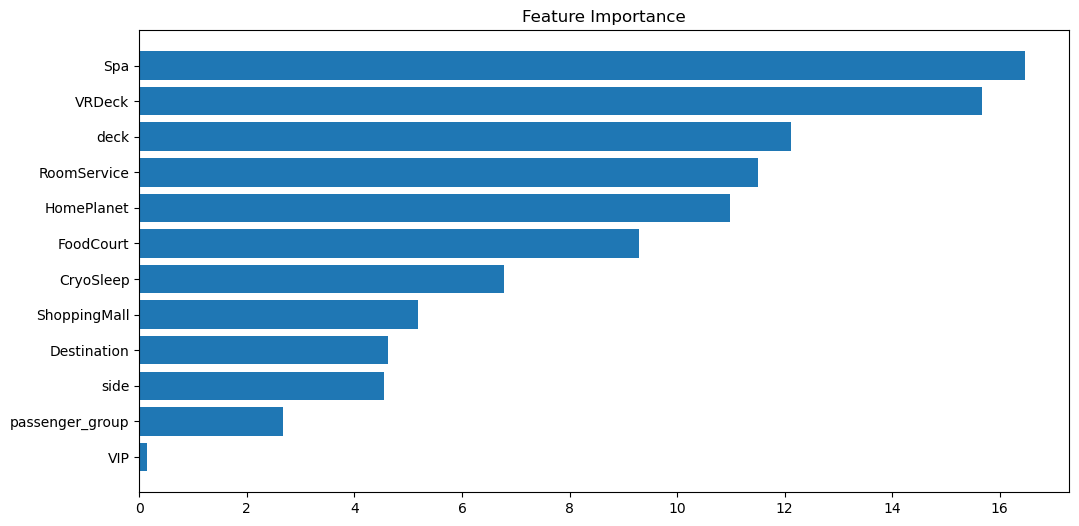

In [222]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')


In [244]:
# SHAP
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('SHAP Importance')


CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=8]=231.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [237]:
reduced_features = list(np.array(X_train.columns)[sorted_idx][1:])
reduced_features

['passenger_group',
 'ShoppingMall',
 'Destination',
 'FoodCourt',
 'side',
 'CryoSleep',
 'deck',
 'RoomService',
 'HomePlanet',
 'VRDeck',
 'Spa']

In [238]:
model.fit(
        X_train[reduced_features]
        ,y_train
        ,cat_features=['passenger_group','Destination','side','CryoSleep','deck','HomePlanet']
        ,plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

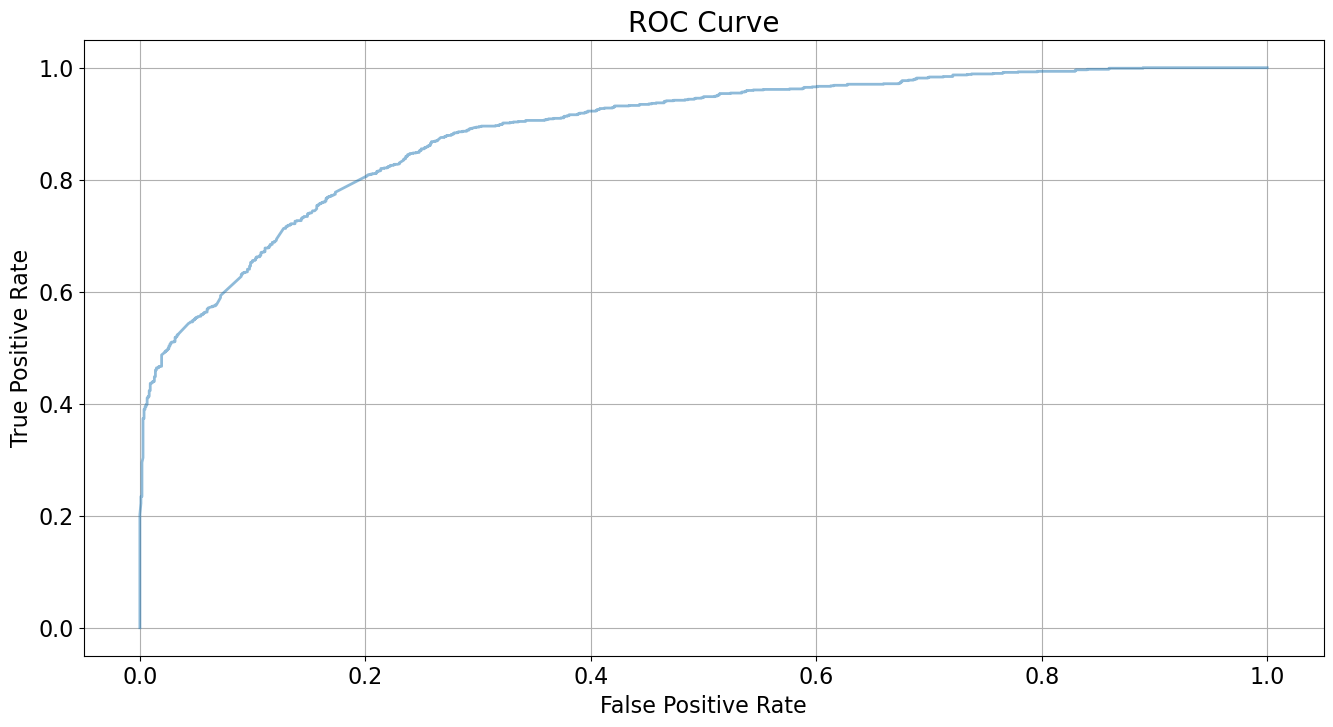

(array([0.        , 0.        , 0.        , ..., 0.99816514, 0.99908257,
        1.        ]),
 array([0.00000000e+00, 9.22509225e-04, 1.84501845e-03, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([1.00000000e+00, 9.99464127e-01, 9.99239776e-01, ...,
        5.80023578e-04, 4.95116755e-04, 0.00000000e+00]))

In [239]:
catboost_pool = Pool(X_val[reduced_features], y_val,\
                     cat_features=['passenger_group','Destination','side','CryoSleep','deck','HomePlanet'])

get_roc_curve(model, 
              catboost_pool,
              thread_count=-1,
              plot=True)

## Submission

In [161]:
test_df_final = test_df[object_cols+spend_cols]

In [162]:
test_df_final

,HomePlanet,CryoSleep,Destination,VIP,deck,side,passenger_group,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Earth,True,TRAPPIST-1e,False,G,S,0013,0.0,0.0,0.0,0.0,0.0
1,Earth,False,TRAPPIST-1e,False,F,S,0018,0.0,9.0,0.0,2823.0,0.0
2,Europa,True,55 Cancri e,False,C,S,0019,0.0,0.0,0.0,0.0,0.0
3,Europa,False,TRAPPIST-1e,False,C,S,0021,0.0,6652.0,0.0,181.0,585.0
4,Earth,False,TRAPPIST-1e,False,F,S,0023,10.0,0.0,635.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,True,TRAPPIST-1e,False,G,S,9266,0.0,0.0,0.0,0.0,0.0
4273,Earth,False,TRAPPIST-1e,False,F,S,9269,0.0,847.0,17.0,10.0,144.0
4274,Mars,True,55 Cancri e,False,D,P,9271,0.0,0.0,0.0,0.0,0.0
4275,Europa,False,TRAPPIST-1e,False,D,P,9273,0.0,2680.0,0.0,0.0,523.0


In [163]:
preds_class = model.predict(test_df_final)
preds_class

array([1, 0, 1, ..., 1, 1, 1])

In [164]:
pd.merge(test_df['PassengerId'],pd.DataFrame(pd.Series(preds_class).replace({1:True,0:False}).values
            ,columns=['Transported']),left_index=True,right_index=True)\
            .to_csv('catboost_submission.csv',index=False)

# Score: 0.80313

## GridSearch

In [110]:
parameters = {'iterations':(10,50,100,200), 'depth':[2,5,10,20,50],'learning_rate':[.25,.1,.01]}
algo = CatBoostClassifier()

model_gs = GridSearchCV(algo,parameters,verbose=True)

model_gs.fit(train_df_final
        ,train_df.Transported
        ,cat_features=object_cols)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
0:	learn: 0.6422891	total: 1.64ms	remaining: 14.7ms
1:	learn: 0.6096598	total: 2.83ms	remaining: 11.3ms
2:	learn: 0.5871305	total: 4.53ms	remaining: 10.6ms
3:	learn: 0.5703837	total: 6.25ms	remaining: 9.37ms
4:	learn: 0.5547204	total: 7.64ms	remaining: 7.64ms
5:	learn: 0.5404631	total: 9.69ms	remaining: 6.46ms
6:	learn: 0.5300812	total: 10.8ms	remaining: 4.61ms
7:	learn: 0.5202839	total: 11.7ms	remaining: 2.92ms
8:	learn: 0.5133513	total: 12.7ms	remaining: 1.41ms
9:	learn: 0.5069943	total: 14.1ms	remaining: 0us
0:	learn: 0.6425002	total: 1.43ms	remaining: 12.9ms
1:	learn: 0.6097807	total: 2.68ms	remaining: 10.7ms
2:	learn: 0.5875900	total: 4.02ms	remaining: 9.37ms
3:	learn: 0.5733908	total: 5.36ms	remaining: 8.04ms
4:	learn: 0.5552791	total: 6.28ms	remaining: 6.28ms
5:	learn: 0.5433056	total: 7.22ms	remaining: 4.81ms
6:	learn: 0.5320185	total: 8.21ms	remaining: 3.52ms
7:	learn: 0.5226571	total: 9.36ms	remaining: 2.34ms
8:	le

21:	learn: 0.4636812	total: 29.4ms	remaining: 37.4ms
22:	learn: 0.4611503	total: 31.3ms	remaining: 36.7ms
23:	learn: 0.4591124	total: 32.8ms	remaining: 35.5ms
24:	learn: 0.4576268	total: 34.4ms	remaining: 34.4ms
25:	learn: 0.4560723	total: 36ms	remaining: 33.2ms
26:	learn: 0.4541270	total: 37.6ms	remaining: 32ms
27:	learn: 0.4528974	total: 40.4ms	remaining: 31.8ms
28:	learn: 0.4517835	total: 42.1ms	remaining: 30.5ms
29:	learn: 0.4502533	total: 43.3ms	remaining: 28.8ms
30:	learn: 0.4485297	total: 44.4ms	remaining: 27.2ms
31:	learn: 0.4475705	total: 45.9ms	remaining: 25.8ms
32:	learn: 0.4457273	total: 47.6ms	remaining: 24.5ms
33:	learn: 0.4437232	total: 49.3ms	remaining: 23.2ms
34:	learn: 0.4423877	total: 50.5ms	remaining: 21.6ms
35:	learn: 0.4413669	total: 51.5ms	remaining: 20ms
36:	learn: 0.4401088	total: 52.9ms	remaining: 18.6ms
37:	learn: 0.4391212	total: 54.3ms	remaining: 17.2ms
38:	learn: 0.4378534	total: 56ms	remaining: 15.8ms
39:	learn: 0.4367395	total: 57.7ms	remaining: 14.4ms
4

0:	learn: 0.6710792	total: 1.36ms	remaining: 66.5ms
1:	learn: 0.6520419	total: 2.94ms	remaining: 70.6ms
2:	learn: 0.6364845	total: 4.04ms	remaining: 63.3ms
3:	learn: 0.6223822	total: 6.69ms	remaining: 76.9ms
4:	learn: 0.6107999	total: 7.73ms	remaining: 69.6ms
5:	learn: 0.6004474	total: 8.85ms	remaining: 64.9ms
6:	learn: 0.5916989	total: 9.97ms	remaining: 61.3ms
7:	learn: 0.5845921	total: 11.4ms	remaining: 60ms
8:	learn: 0.5761750	total: 12.6ms	remaining: 57.6ms
9:	learn: 0.5690688	total: 13.8ms	remaining: 55ms
10:	learn: 0.5643381	total: 14.9ms	remaining: 52.7ms
11:	learn: 0.5596252	total: 16ms	remaining: 50.5ms
12:	learn: 0.5533165	total: 17.2ms	remaining: 48.8ms
13:	learn: 0.5477782	total: 18.2ms	remaining: 46.7ms
14:	learn: 0.5426419	total: 19.4ms	remaining: 45.2ms
15:	learn: 0.5388982	total: 21.2ms	remaining: 45.1ms
16:	learn: 0.5346004	total: 22.3ms	remaining: 43.3ms
17:	learn: 0.5304816	total: 23.5ms	remaining: 41.7ms
18:	learn: 0.5267100	total: 24.5ms	remaining: 40ms
19:	learn: 

0:	learn: 0.6705311	total: 3.12ms	remaining: 153ms
1:	learn: 0.6520682	total: 4.54ms	remaining: 109ms
2:	learn: 0.6365142	total: 5.41ms	remaining: 84.7ms
3:	learn: 0.6242118	total: 6.39ms	remaining: 73.5ms
4:	learn: 0.6139756	total: 7.41ms	remaining: 66.7ms
5:	learn: 0.6045941	total: 8.31ms	remaining: 61ms
6:	learn: 0.5962392	total: 9.36ms	remaining: 57.5ms
7:	learn: 0.5894025	total: 10.3ms	remaining: 54.2ms
8:	learn: 0.5808707	total: 11.2ms	remaining: 51.1ms
9:	learn: 0.5731633	total: 12.3ms	remaining: 49.4ms
10:	learn: 0.5664559	total: 13.2ms	remaining: 46.8ms
11:	learn: 0.5616916	total: 15ms	remaining: 47.6ms
12:	learn: 0.5560361	total: 16.1ms	remaining: 45.8ms
13:	learn: 0.5517640	total: 17ms	remaining: 43.8ms
14:	learn: 0.5466412	total: 18.2ms	remaining: 42.5ms
15:	learn: 0.5424532	total: 19.6ms	remaining: 41.6ms
16:	learn: 0.5379461	total: 20.6ms	remaining: 40ms
17:	learn: 0.5340396	total: 21.7ms	remaining: 38.6ms
18:	learn: 0.5305686	total: 23ms	remaining: 37.5ms
19:	learn: 0.52

0:	learn: 0.6906598	total: 1.28ms	remaining: 62.8ms
1:	learn: 0.6882214	total: 4.53ms	remaining: 109ms
2:	learn: 0.6860615	total: 5.74ms	remaining: 89.9ms
3:	learn: 0.6837099	total: 6.95ms	remaining: 80ms
4:	learn: 0.6815690	total: 7.97ms	remaining: 71.8ms
5:	learn: 0.6793034	total: 9.19ms	remaining: 67.4ms
6:	learn: 0.6770831	total: 10.2ms	remaining: 62.5ms
7:	learn: 0.6749034	total: 12.4ms	remaining: 65.1ms
8:	learn: 0.6727657	total: 13.4ms	remaining: 60.9ms
9:	learn: 0.6706701	total: 14.7ms	remaining: 58.8ms
10:	learn: 0.6686117	total: 15.7ms	remaining: 55.6ms
11:	learn: 0.6665923	total: 16.7ms	remaining: 53ms
12:	learn: 0.6646101	total: 18.5ms	remaining: 52.5ms
13:	learn: 0.6626646	total: 19.9ms	remaining: 51.2ms
14:	learn: 0.6607597	total: 20.8ms	remaining: 48.4ms
15:	learn: 0.6589343	total: 21.7ms	remaining: 46.1ms
16:	learn: 0.6570906	total: 23ms	remaining: 44.7ms
17:	learn: 0.6552791	total: 24.1ms	remaining: 42.9ms
18:	learn: 0.6535995	total: 25.3ms	remaining: 41.2ms
19:	learn:

25:	learn: 0.4560723	total: 32.5ms	remaining: 92.6ms
26:	learn: 0.4541270	total: 34.2ms	remaining: 92.4ms
27:	learn: 0.4528974	total: 35.2ms	remaining: 90.6ms
28:	learn: 0.4517835	total: 36.2ms	remaining: 88.7ms
29:	learn: 0.4502533	total: 37.2ms	remaining: 86.7ms
30:	learn: 0.4485297	total: 38.4ms	remaining: 85.4ms
31:	learn: 0.4475705	total: 39.5ms	remaining: 83.9ms
32:	learn: 0.4457273	total: 40.4ms	remaining: 82.1ms
33:	learn: 0.4437232	total: 42.2ms	remaining: 81.9ms
34:	learn: 0.4423877	total: 43.2ms	remaining: 80.2ms
35:	learn: 0.4413669	total: 44.1ms	remaining: 78.4ms
36:	learn: 0.4401088	total: 45.1ms	remaining: 76.7ms
37:	learn: 0.4391212	total: 46.1ms	remaining: 75.2ms
38:	learn: 0.4378534	total: 47ms	remaining: 73.6ms
39:	learn: 0.4367395	total: 48.2ms	remaining: 72.3ms
40:	learn: 0.4359301	total: 49.4ms	remaining: 71ms
41:	learn: 0.4345821	total: 50.6ms	remaining: 69.9ms
42:	learn: 0.4337776	total: 53.6ms	remaining: 71.1ms
43:	learn: 0.4330969	total: 55ms	remaining: 70ms
4

66:	learn: 0.4243343	total: 79.9ms	remaining: 39.3ms
67:	learn: 0.4242435	total: 81.3ms	remaining: 38.3ms
68:	learn: 0.4242402	total: 82.4ms	remaining: 37ms
69:	learn: 0.4240198	total: 83.5ms	remaining: 35.8ms
70:	learn: 0.4236989	total: 84.7ms	remaining: 34.6ms
71:	learn: 0.4234313	total: 85.6ms	remaining: 33.3ms
72:	learn: 0.4234295	total: 86.6ms	remaining: 32ms
73:	learn: 0.4230149	total: 87.6ms	remaining: 30.8ms
74:	learn: 0.4228012	total: 88.7ms	remaining: 29.6ms
75:	learn: 0.4226556	total: 89.8ms	remaining: 28.4ms
76:	learn: 0.4221565	total: 91.1ms	remaining: 27.2ms
77:	learn: 0.4220199	total: 92.1ms	remaining: 26ms
78:	learn: 0.4215402	total: 93.3ms	remaining: 24.8ms
79:	learn: 0.4213920	total: 94.4ms	remaining: 23.6ms
80:	learn: 0.4203349	total: 95.7ms	remaining: 22.4ms
81:	learn: 0.4194025	total: 97.5ms	remaining: 21.4ms
82:	learn: 0.4192805	total: 98.7ms	remaining: 20.2ms
83:	learn: 0.4192049	total: 99.9ms	remaining: 19ms
84:	learn: 0.4189169	total: 101ms	remaining: 17.9ms
85

99:	learn: 0.4391047	total: 113ms	remaining: 0us
0:	learn: 0.6711710	total: 1.28ms	remaining: 127ms
1:	learn: 0.6522007	total: 2.29ms	remaining: 112ms
2:	learn: 0.6368640	total: 3.32ms	remaining: 107ms
3:	learn: 0.6239796	total: 4.44ms	remaining: 107ms
4:	learn: 0.6122827	total: 5.31ms	remaining: 101ms
5:	learn: 0.6020850	total: 6.38ms	remaining: 100ms
6:	learn: 0.5917663	total: 7.35ms	remaining: 97.7ms
7:	learn: 0.5842927	total: 8.77ms	remaining: 101ms
8:	learn: 0.5781744	total: 9.85ms	remaining: 99.5ms
9:	learn: 0.5704640	total: 11ms	remaining: 99.2ms
10:	learn: 0.5646159	total: 12.1ms	remaining: 97.8ms
11:	learn: 0.5587342	total: 13.6ms	remaining: 99.8ms
12:	learn: 0.5521969	total: 14.6ms	remaining: 97.6ms
13:	learn: 0.5466413	total: 15.5ms	remaining: 95.5ms
14:	learn: 0.5426389	total: 16.5ms	remaining: 93.3ms
15:	learn: 0.5386220	total: 17.5ms	remaining: 91.9ms
16:	learn: 0.5338994	total: 20.6ms	remaining: 101ms
17:	learn: 0.5301713	total: 22.1ms	remaining: 101ms
18:	learn: 0.52659

22:	learn: 0.5139717	total: 26.1ms	remaining: 87.2ms
23:	learn: 0.5112594	total: 27.9ms	remaining: 88.5ms
24:	learn: 0.5084149	total: 29ms	remaining: 87ms
25:	learn: 0.5064744	total: 30.1ms	remaining: 85.7ms
26:	learn: 0.5038476	total: 31.1ms	remaining: 84.2ms
27:	learn: 0.5013932	total: 32.3ms	remaining: 82.9ms
28:	learn: 0.4993312	total: 33.6ms	remaining: 82.2ms
29:	learn: 0.4975011	total: 35.6ms	remaining: 83ms
30:	learn: 0.4952882	total: 36.5ms	remaining: 81.3ms
31:	learn: 0.4940583	total: 37.7ms	remaining: 80.1ms
32:	learn: 0.4923936	total: 38.6ms	remaining: 78.4ms
33:	learn: 0.4906102	total: 39.5ms	remaining: 76.8ms
34:	learn: 0.4888782	total: 41ms	remaining: 76.2ms
35:	learn: 0.4876184	total: 42.1ms	remaining: 74.9ms
36:	learn: 0.4863823	total: 43.1ms	remaining: 73.4ms
37:	learn: 0.4846933	total: 44.1ms	remaining: 71.9ms
38:	learn: 0.4831531	total: 45.1ms	remaining: 70.5ms
39:	learn: 0.4818370	total: 46.1ms	remaining: 69.2ms
40:	learn: 0.4807493	total: 47.4ms	remaining: 68.2ms
4

67:	learn: 0.5954555	total: 70.3ms	remaining: 33.1ms
68:	learn: 0.5946674	total: 72.4ms	remaining: 32.5ms
69:	learn: 0.5936649	total: 73.5ms	remaining: 31.5ms
70:	learn: 0.5928606	total: 75ms	remaining: 30.6ms
71:	learn: 0.5920475	total: 76.3ms	remaining: 29.7ms
72:	learn: 0.5913042	total: 77.3ms	remaining: 28.6ms
73:	learn: 0.5905535	total: 78.3ms	remaining: 27.5ms
74:	learn: 0.5895640	total: 79.4ms	remaining: 26.5ms
75:	learn: 0.5888453	total: 80.8ms	remaining: 25.5ms
76:	learn: 0.5881788	total: 81.7ms	remaining: 24.4ms
77:	learn: 0.5874842	total: 82.6ms	remaining: 23.3ms
78:	learn: 0.5865466	total: 83.7ms	remaining: 22.2ms
79:	learn: 0.5858623	total: 84.7ms	remaining: 21.2ms
80:	learn: 0.5851971	total: 85.7ms	remaining: 20.1ms
81:	learn: 0.5844935	total: 87ms	remaining: 19.1ms
82:	learn: 0.5836124	total: 88.5ms	remaining: 18.1ms
83:	learn: 0.5829184	total: 89.5ms	remaining: 17ms
84:	learn: 0.5820302	total: 90.7ms	remaining: 16ms
85:	learn: 0.5813433	total: 92.2ms	remaining: 15ms
86:

31:	learn: 0.6338378	total: 34.9ms	remaining: 74.2ms
32:	learn: 0.6324303	total: 36.4ms	remaining: 73.9ms
33:	learn: 0.6311610	total: 37.5ms	remaining: 72.8ms
34:	learn: 0.6298016	total: 38.5ms	remaining: 71.5ms
35:	learn: 0.6285118	total: 39.3ms	remaining: 69.9ms
36:	learn: 0.6271903	total: 40.2ms	remaining: 68.4ms
37:	learn: 0.6259286	total: 41ms	remaining: 66.9ms
38:	learn: 0.6246481	total: 41.9ms	remaining: 65.5ms
39:	learn: 0.6235059	total: 42.7ms	remaining: 64.1ms
40:	learn: 0.6222740	total: 43.8ms	remaining: 63ms
41:	learn: 0.6210817	total: 44.6ms	remaining: 61.6ms
42:	learn: 0.6198923	total: 46.2ms	remaining: 61.2ms
43:	learn: 0.6187567	total: 47.1ms	remaining: 59.9ms
44:	learn: 0.6175881	total: 48ms	remaining: 58.6ms
45:	learn: 0.6164801	total: 48.9ms	remaining: 57.4ms
46:	learn: 0.6153466	total: 49.8ms	remaining: 56.2ms
47:	learn: 0.6142307	total: 50.7ms	remaining: 54.9ms
48:	learn: 0.6131591	total: 51.5ms	remaining: 53.6ms
49:	learn: 0.6120764	total: 52.7ms	remaining: 52.7ms

35:	learn: 0.4296287	total: 110ms	remaining: 501ms
36:	learn: 0.4289890	total: 113ms	remaining: 496ms
37:	learn: 0.4278557	total: 115ms	remaining: 491ms
38:	learn: 0.4270171	total: 119ms	remaining: 490ms
39:	learn: 0.4265266	total: 121ms	remaining: 486ms
40:	learn: 0.4257058	total: 125ms	remaining: 484ms
41:	learn: 0.4243342	total: 127ms	remaining: 479ms
42:	learn: 0.4236489	total: 130ms	remaining: 475ms
43:	learn: 0.4224989	total: 134ms	remaining: 476ms
44:	learn: 0.4211324	total: 138ms	remaining: 476ms
45:	learn: 0.4204781	total: 142ms	remaining: 475ms
46:	learn: 0.4200498	total: 144ms	remaining: 470ms
47:	learn: 0.4194587	total: 148ms	remaining: 467ms
48:	learn: 0.4189547	total: 151ms	remaining: 465ms
49:	learn: 0.4185458	total: 153ms	remaining: 460ms
50:	learn: 0.4178273	total: 156ms	remaining: 455ms
51:	learn: 0.4172029	total: 158ms	remaining: 449ms
52:	learn: 0.4167012	total: 161ms	remaining: 445ms
53:	learn: 0.4163792	total: 163ms	remaining: 442ms
54:	learn: 0.4158853	total: 166

17:	learn: 0.4620078	total: 65.1ms	remaining: 659ms
18:	learn: 0.4583387	total: 67.8ms	remaining: 646ms
19:	learn: 0.4558472	total: 70.5ms	remaining: 634ms
20:	learn: 0.4528962	total: 73.6ms	remaining: 627ms
21:	learn: 0.4517202	total: 77.1ms	remaining: 624ms
22:	learn: 0.4506723	total: 80.2ms	remaining: 617ms
23:	learn: 0.4491396	total: 83ms	remaining: 609ms
24:	learn: 0.4478965	total: 86.1ms	remaining: 603ms
25:	learn: 0.4465608	total: 88.7ms	remaining: 594ms
26:	learn: 0.4457581	total: 92.2ms	remaining: 591ms
27:	learn: 0.4437143	total: 95ms	remaining: 584ms
28:	learn: 0.4422380	total: 99.4ms	remaining: 586ms
29:	learn: 0.4403601	total: 102ms	remaining: 579ms
30:	learn: 0.4394478	total: 104ms	remaining: 570ms
31:	learn: 0.4375198	total: 108ms	remaining: 567ms
32:	learn: 0.4366327	total: 111ms	remaining: 563ms
33:	learn: 0.4353775	total: 114ms	remaining: 556ms
34:	learn: 0.4346048	total: 116ms	remaining: 547ms
35:	learn: 0.4339706	total: 119ms	remaining: 541ms
36:	learn: 0.4324391	to

0:	learn: 0.6116196	total: 3.46ms	remaining: 688ms
1:	learn: 0.5854179	total: 7.4ms	remaining: 733ms
2:	learn: 0.5600623	total: 10ms	remaining: 658ms
3:	learn: 0.5426348	total: 12.5ms	remaining: 613ms
4:	learn: 0.5258809	total: 17ms	remaining: 663ms
5:	learn: 0.5151343	total: 20.4ms	remaining: 659ms
6:	learn: 0.5077222	total: 23.7ms	remaining: 655ms
7:	learn: 0.4992959	total: 26.3ms	remaining: 631ms
8:	learn: 0.4918675	total: 28.5ms	remaining: 606ms
9:	learn: 0.4851260	total: 31.1ms	remaining: 591ms
10:	learn: 0.4806349	total: 34ms	remaining: 584ms
11:	learn: 0.4749039	total: 36.9ms	remaining: 578ms
12:	learn: 0.4696596	total: 39.3ms	remaining: 565ms
13:	learn: 0.4673232	total: 42.4ms	remaining: 563ms
14:	learn: 0.4642236	total: 44.6ms	remaining: 550ms
15:	learn: 0.4609245	total: 49.2ms	remaining: 566ms
16:	learn: 0.4577353	total: 52.7ms	remaining: 567ms
17:	learn: 0.4561843	total: 55.8ms	remaining: 564ms
18:	learn: 0.4526163	total: 58.5ms	remaining: 557ms
19:	learn: 0.4502930	total: 6

0:	learn: 0.6111139	total: 2.93ms	remaining: 584ms
1:	learn: 0.5770676	total: 6.61ms	remaining: 654ms
2:	learn: 0.5511789	total: 10.3ms	remaining: 678ms
3:	learn: 0.5351868	total: 14.1ms	remaining: 692ms
4:	learn: 0.5228900	total: 18.2ms	remaining: 711ms
5:	learn: 0.5129641	total: 24ms	remaining: 777ms
6:	learn: 0.5052728	total: 27ms	remaining: 743ms
7:	learn: 0.4960669	total: 29.6ms	remaining: 710ms
8:	learn: 0.4917097	total: 32.6ms	remaining: 693ms
9:	learn: 0.4848457	total: 36.3ms	remaining: 689ms
10:	learn: 0.4795488	total: 39.4ms	remaining: 677ms
11:	learn: 0.4747154	total: 43.3ms	remaining: 678ms
12:	learn: 0.4716811	total: 46ms	remaining: 661ms
13:	learn: 0.4696251	total: 48.6ms	remaining: 645ms
14:	learn: 0.4668116	total: 50.9ms	remaining: 628ms
15:	learn: 0.4638425	total: 55.6ms	remaining: 639ms
16:	learn: 0.4616201	total: 58.3ms	remaining: 628ms
17:	learn: 0.4598017	total: 60.9ms	remaining: 616ms
18:	learn: 0.4576246	total: 64ms	remaining: 610ms
19:	learn: 0.4549982	total: 66

0:	learn: 0.6160708	total: 3.14ms	remaining: 625ms
1:	learn: 0.5839706	total: 6.38ms	remaining: 632ms
2:	learn: 0.5583251	total: 9.03ms	remaining: 593ms
3:	learn: 0.5400301	total: 11.2ms	remaining: 548ms
4:	learn: 0.5282842	total: 13.3ms	remaining: 517ms
5:	learn: 0.5177326	total: 15.5ms	remaining: 500ms
6:	learn: 0.5109004	total: 18.2ms	remaining: 503ms
7:	learn: 0.5043988	total: 20.4ms	remaining: 489ms
8:	learn: 0.4981725	total: 22.9ms	remaining: 485ms
9:	learn: 0.4925663	total: 27.1ms	remaining: 514ms
10:	learn: 0.4873117	total: 30.6ms	remaining: 526ms
11:	learn: 0.4837324	total: 33ms	remaining: 517ms
12:	learn: 0.4786595	total: 36.8ms	remaining: 530ms
13:	learn: 0.4748753	total: 39.2ms	remaining: 521ms
14:	learn: 0.4716464	total: 42.5ms	remaining: 524ms
15:	learn: 0.4678577	total: 44.6ms	remaining: 513ms
16:	learn: 0.4661452	total: 46.7ms	remaining: 502ms
17:	learn: 0.4620586	total: 48.9ms	remaining: 495ms
18:	learn: 0.4586396	total: 51.4ms	remaining: 490ms
19:	learn: 0.4571127	tot

0:	learn: 0.6564206	total: 4.28ms	remaining: 852ms
1:	learn: 0.6349453	total: 8.12ms	remaining: 804ms
2:	learn: 0.6150065	total: 10.9ms	remaining: 713ms
3:	learn: 0.6025332	total: 13.5ms	remaining: 661ms
4:	learn: 0.5906303	total: 15.4ms	remaining: 603ms
5:	learn: 0.5773526	total: 19.7ms	remaining: 636ms
6:	learn: 0.5693547	total: 21.9ms	remaining: 605ms
7:	learn: 0.5609399	total: 24.9ms	remaining: 597ms
8:	learn: 0.5525703	total: 27.6ms	remaining: 585ms
9:	learn: 0.5459950	total: 30.1ms	remaining: 571ms
10:	learn: 0.5397006	total: 33ms	remaining: 567ms
11:	learn: 0.5334809	total: 35.6ms	remaining: 558ms
12:	learn: 0.5280631	total: 38.7ms	remaining: 557ms
13:	learn: 0.5235850	total: 41.4ms	remaining: 551ms
14:	learn: 0.5192320	total: 44.2ms	remaining: 546ms
15:	learn: 0.5155570	total: 46.6ms	remaining: 536ms
16:	learn: 0.5117706	total: 49.1ms	remaining: 529ms
17:	learn: 0.5079790	total: 51.9ms	remaining: 524ms
18:	learn: 0.5056483	total: 54.3ms	remaining: 517ms
19:	learn: 0.5025279	tot

0:	learn: 0.6563470	total: 2.97ms	remaining: 590ms
1:	learn: 0.6379161	total: 7.61ms	remaining: 753ms
2:	learn: 0.6213299	total: 9.68ms	remaining: 636ms
3:	learn: 0.6038657	total: 11.8ms	remaining: 580ms
4:	learn: 0.5922510	total: 14.2ms	remaining: 553ms
5:	learn: 0.5796433	total: 17.9ms	remaining: 579ms
6:	learn: 0.5689189	total: 20.1ms	remaining: 555ms
7:	learn: 0.5594810	total: 22.2ms	remaining: 532ms
8:	learn: 0.5538819	total: 23.9ms	remaining: 508ms
9:	learn: 0.5474815	total: 26.3ms	remaining: 500ms
10:	learn: 0.5413259	total: 29.3ms	remaining: 504ms
11:	learn: 0.5356221	total: 32.6ms	remaining: 510ms
12:	learn: 0.5308146	total: 34.9ms	remaining: 503ms
13:	learn: 0.5259266	total: 37.6ms	remaining: 499ms
14:	learn: 0.5219303	total: 40.1ms	remaining: 495ms
15:	learn: 0.5184862	total: 43ms	remaining: 495ms
16:	learn: 0.5147516	total: 45.8ms	remaining: 493ms
17:	learn: 0.5107111	total: 48.7ms	remaining: 492ms
18:	learn: 0.5075951	total: 51.1ms	remaining: 487ms
19:	learn: 0.5047713	tot

0:	learn: 0.6553645	total: 3.33ms	remaining: 662ms
1:	learn: 0.6365320	total: 6.35ms	remaining: 628ms
2:	learn: 0.6207431	total: 8.9ms	remaining: 584ms
3:	learn: 0.6030209	total: 11.8ms	remaining: 578ms
4:	learn: 0.5891632	total: 15ms	remaining: 584ms
5:	learn: 0.5821356	total: 17.7ms	remaining: 571ms
6:	learn: 0.5702325	total: 21ms	remaining: 579ms
7:	learn: 0.5613342	total: 23.2ms	remaining: 557ms
8:	learn: 0.5535763	total: 25.6ms	remaining: 544ms
9:	learn: 0.5464471	total: 27.7ms	remaining: 527ms
10:	learn: 0.5407977	total: 30.3ms	remaining: 520ms
11:	learn: 0.5349837	total: 32.7ms	remaining: 512ms
12:	learn: 0.5298820	total: 35.1ms	remaining: 504ms
13:	learn: 0.5248395	total: 37.2ms	remaining: 495ms
14:	learn: 0.5199975	total: 40.2ms	remaining: 496ms
15:	learn: 0.5164280	total: 43.7ms	remaining: 502ms
16:	learn: 0.5119427	total: 46.5ms	remaining: 501ms
17:	learn: 0.5074617	total: 49ms	remaining: 496ms
18:	learn: 0.5033083	total: 52.5ms	remaining: 500ms
19:	learn: 0.5006228	total: 5

0:	learn: 0.6550932	total: 2.87ms	remaining: 570ms
1:	learn: 0.6294578	total: 6.36ms	remaining: 630ms
2:	learn: 0.6093778	total: 9.62ms	remaining: 632ms
3:	learn: 0.5968333	total: 12.2ms	remaining: 600ms
4:	learn: 0.5878158	total: 14.6ms	remaining: 569ms
5:	learn: 0.5791021	total: 17.6ms	remaining: 569ms
6:	learn: 0.5691236	total: 20ms	remaining: 551ms
7:	learn: 0.5606859	total: 23.1ms	remaining: 555ms
8:	learn: 0.5509499	total: 25.3ms	remaining: 537ms
9:	learn: 0.5452334	total: 27.8ms	remaining: 527ms
10:	learn: 0.5397058	total: 29.9ms	remaining: 514ms
11:	learn: 0.5334834	total: 32.9ms	remaining: 516ms
12:	learn: 0.5283282	total: 35.2ms	remaining: 507ms
13:	learn: 0.5232184	total: 37.5ms	remaining: 498ms
14:	learn: 0.5197172	total: 40.2ms	remaining: 496ms
15:	learn: 0.5161423	total: 42.5ms	remaining: 489ms
16:	learn: 0.5117954	total: 45.1ms	remaining: 485ms
17:	learn: 0.5085572	total: 48.3ms	remaining: 489ms
18:	learn: 0.5056241	total: 51.1ms	remaining: 487ms
19:	learn: 0.5027058	tot

0:	learn: 0.6575473	total: 3.64ms	remaining: 724ms
1:	learn: 0.6342144	total: 8.26ms	remaining: 817ms
2:	learn: 0.6200779	total: 11.1ms	remaining: 730ms
3:	learn: 0.6084265	total: 15.4ms	remaining: 755ms
4:	learn: 0.5990934	total: 22ms	remaining: 858ms
5:	learn: 0.5855385	total: 25.9ms	remaining: 837ms
6:	learn: 0.5742612	total: 29.2ms	remaining: 805ms
7:	learn: 0.5679688	total: 31.4ms	remaining: 754ms
8:	learn: 0.5597626	total: 34.4ms	remaining: 729ms
9:	learn: 0.5539606	total: 37.6ms	remaining: 714ms
10:	learn: 0.5470530	total: 40.6ms	remaining: 698ms
11:	learn: 0.5415718	total: 46.2ms	remaining: 724ms
12:	learn: 0.5370460	total: 49.6ms	remaining: 713ms
13:	learn: 0.5323310	total: 54ms	remaining: 718ms
14:	learn: 0.5273759	total: 56.9ms	remaining: 702ms
15:	learn: 0.5241433	total: 59.7ms	remaining: 687ms
16:	learn: 0.5206992	total: 70.9ms	remaining: 763ms
17:	learn: 0.5177270	total: 75.2ms	remaining: 760ms
18:	learn: 0.5154461	total: 79.7ms	remaining: 759ms
19:	learn: 0.5123738	total

0:	learn: 0.6891699	total: 4.07ms	remaining: 810ms
1:	learn: 0.6863244	total: 6.75ms	remaining: 668ms
2:	learn: 0.6830514	total: 8.82ms	remaining: 579ms
3:	learn: 0.6804961	total: 11.8ms	remaining: 579ms
4:	learn: 0.6769362	total: 14.9ms	remaining: 581ms
5:	learn: 0.6734211	total: 17.2ms	remaining: 557ms
6:	learn: 0.6705407	total: 19.1ms	remaining: 527ms
7:	learn: 0.6671704	total: 21.6ms	remaining: 519ms
8:	learn: 0.6649071	total: 23.8ms	remaining: 505ms
9:	learn: 0.6616806	total: 26ms	remaining: 494ms
10:	learn: 0.6589786	total: 28.2ms	remaining: 485ms
11:	learn: 0.6564316	total: 30.8ms	remaining: 483ms
12:	learn: 0.6542081	total: 34ms	remaining: 489ms
13:	learn: 0.6520371	total: 36ms	remaining: 478ms
14:	learn: 0.6499611	total: 38.4ms	remaining: 474ms
15:	learn: 0.6470737	total: 41.4ms	remaining: 476ms
16:	learn: 0.6448578	total: 43.6ms	remaining: 469ms
17:	learn: 0.6428499	total: 45.4ms	remaining: 459ms
18:	learn: 0.6401690	total: 47.4ms	remaining: 452ms
19:	learn: 0.6383769	total: 

11:	learn: 0.6557095	total: 29.8ms	remaining: 467ms
12:	learn: 0.6535397	total: 32.6ms	remaining: 469ms
13:	learn: 0.6509114	total: 35ms	remaining: 465ms
14:	learn: 0.6488673	total: 38.1ms	remaining: 470ms
15:	learn: 0.6468744	total: 41.4ms	remaining: 476ms
16:	learn: 0.6443913	total: 44.6ms	remaining: 480ms
17:	learn: 0.6425438	total: 47.1ms	remaining: 476ms
18:	learn: 0.6398635	total: 50.7ms	remaining: 483ms
19:	learn: 0.6375610	total: 52.8ms	remaining: 475ms
20:	learn: 0.6350427	total: 55.1ms	remaining: 469ms
21:	learn: 0.6332192	total: 56.8ms	remaining: 460ms
22:	learn: 0.6308895	total: 59.3ms	remaining: 456ms
23:	learn: 0.6287929	total: 61.5ms	remaining: 451ms
24:	learn: 0.6271315	total: 63.6ms	remaining: 445ms
25:	learn: 0.6251328	total: 65.9ms	remaining: 441ms
26:	learn: 0.6235669	total: 68.9ms	remaining: 442ms
27:	learn: 0.6218319	total: 72ms	remaining: 442ms
28:	learn: 0.6199773	total: 73.9ms	remaining: 436ms
29:	learn: 0.6186297	total: 75.7ms	remaining: 429ms
30:	learn: 0.617

20:	learn: 0.6333692	total: 54.2ms	remaining: 462ms
21:	learn: 0.6313136	total: 57ms	remaining: 461ms
22:	learn: 0.6295426	total: 58.9ms	remaining: 453ms
23:	learn: 0.6281489	total: 60.9ms	remaining: 447ms
24:	learn: 0.6264810	total: 63.3ms	remaining: 443ms
25:	learn: 0.6249643	total: 65ms	remaining: 435ms
26:	learn: 0.6229527	total: 66.9ms	remaining: 429ms
27:	learn: 0.6214890	total: 69.1ms	remaining: 425ms
28:	learn: 0.6192225	total: 71.6ms	remaining: 422ms
29:	learn: 0.6178295	total: 73.7ms	remaining: 418ms
30:	learn: 0.6164618	total: 76.3ms	remaining: 416ms
31:	learn: 0.6145975	total: 79.5ms	remaining: 417ms
32:	learn: 0.6127913	total: 82.3ms	remaining: 416ms
33:	learn: 0.6115100	total: 85.1ms	remaining: 415ms
34:	learn: 0.6102399	total: 88.1ms	remaining: 415ms
35:	learn: 0.6090042	total: 90.2ms	remaining: 411ms
36:	learn: 0.6076909	total: 92.2ms	remaining: 406ms
37:	learn: 0.6065107	total: 94.4ms	remaining: 403ms
38:	learn: 0.6048790	total: 96.5ms	remaining: 398ms
39:	learn: 0.603

6:	learn: 0.6680009	total: 20.6ms	remaining: 569ms
7:	learn: 0.6651859	total: 23.1ms	remaining: 555ms
8:	learn: 0.6621521	total: 25.1ms	remaining: 532ms
9:	learn: 0.6591974	total: 27.1ms	remaining: 514ms
10:	learn: 0.6563198	total: 30ms	remaining: 516ms
11:	learn: 0.6537444	total: 32.2ms	remaining: 505ms
12:	learn: 0.6510484	total: 36.6ms	remaining: 526ms
13:	learn: 0.6483790	total: 39ms	remaining: 519ms
14:	learn: 0.6457876	total: 41ms	remaining: 506ms
15:	learn: 0.6432924	total: 43.3ms	remaining: 498ms
16:	learn: 0.6408261	total: 46.1ms	remaining: 497ms
17:	learn: 0.6390777	total: 47.9ms	remaining: 484ms
18:	learn: 0.6367527	total: 49.9ms	remaining: 475ms
19:	learn: 0.6349411	total: 51.8ms	remaining: 466ms
20:	learn: 0.6332884	total: 53.8ms	remaining: 459ms
21:	learn: 0.6310559	total: 56ms	remaining: 453ms
22:	learn: 0.6288850	total: 57.8ms	remaining: 445ms
23:	learn: 0.6267715	total: 59.8ms	remaining: 438ms
24:	learn: 0.6252070	total: 62.4ms	remaining: 436ms
25:	learn: 0.6237256	tot

21:	learn: 0.6342659	total: 54ms	remaining: 437ms
22:	learn: 0.6319904	total: 57.4ms	remaining: 442ms
23:	learn: 0.6297754	total: 61ms	remaining: 447ms
24:	learn: 0.6283395	total: 63.7ms	remaining: 446ms
25:	learn: 0.6268604	total: 66.6ms	remaining: 446ms
26:	learn: 0.6248822	total: 68.8ms	remaining: 441ms
27:	learn: 0.6229636	total: 71.2ms	remaining: 438ms
28:	learn: 0.6216020	total: 73.1ms	remaining: 431ms
29:	learn: 0.6199108	total: 75ms	remaining: 425ms
30:	learn: 0.6186111	total: 76.7ms	remaining: 418ms
31:	learn: 0.6172284	total: 78.7ms	remaining: 413ms
32:	learn: 0.6159311	total: 80.5ms	remaining: 408ms
33:	learn: 0.6145479	total: 82.8ms	remaining: 404ms
34:	learn: 0.6133508	total: 84.8ms	remaining: 400ms
35:	learn: 0.6120685	total: 87.6ms	remaining: 399ms
36:	learn: 0.6107628	total: 89.6ms	remaining: 395ms
37:	learn: 0.6090382	total: 91.6ms	remaining: 391ms
38:	learn: 0.6073916	total: 95ms	remaining: 392ms
39:	learn: 0.6061829	total: 97ms	remaining: 388ms
40:	learn: 0.6050977	t

0:	learn: 0.6295313	total: 1.72ms	remaining: 15.4ms
1:	learn: 0.5874181	total: 3.75ms	remaining: 15ms
2:	learn: 0.5483364	total: 5.77ms	remaining: 13.5ms
3:	learn: 0.5250561	total: 7.83ms	remaining: 11.7ms
4:	learn: 0.5045799	total: 9.46ms	remaining: 9.46ms
5:	learn: 0.4913965	total: 12.3ms	remaining: 8.21ms
6:	learn: 0.4804640	total: 15.1ms	remaining: 6.46ms
7:	learn: 0.4733518	total: 17.6ms	remaining: 4.39ms
8:	learn: 0.4656345	total: 19.7ms	remaining: 2.18ms
9:	learn: 0.4581046	total: 21.9ms	remaining: 0us
0:	learn: 0.6271852	total: 2.06ms	remaining: 18.5ms
1:	learn: 0.5838320	total: 3.71ms	remaining: 14.9ms
2:	learn: 0.5467835	total: 5.28ms	remaining: 12.3ms
3:	learn: 0.5202800	total: 7.9ms	remaining: 11.9ms
4:	learn: 0.5011544	total: 9.68ms	remaining: 9.68ms
5:	learn: 0.4900985	total: 11.7ms	remaining: 7.8ms
6:	learn: 0.4789624	total: 13.3ms	remaining: 5.72ms
7:	learn: 0.4706854	total: 15.6ms	remaining: 3.9ms
8:	learn: 0.4634799	total: 17.8ms	remaining: 1.97ms
9:	learn: 0.4574007	

0:	learn: 0.6295313	total: 2.24ms	remaining: 110ms
1:	learn: 0.5874181	total: 4.32ms	remaining: 104ms
2:	learn: 0.5483364	total: 5.82ms	remaining: 91.1ms
3:	learn: 0.5250561	total: 7.94ms	remaining: 91.3ms
4:	learn: 0.5045799	total: 9.72ms	remaining: 87.5ms
5:	learn: 0.4913965	total: 11.4ms	remaining: 83.7ms
6:	learn: 0.4804640	total: 13.6ms	remaining: 83.6ms
7:	learn: 0.4733518	total: 15.2ms	remaining: 79.9ms
8:	learn: 0.4656345	total: 17.7ms	remaining: 80.7ms
9:	learn: 0.4581046	total: 20.4ms	remaining: 81.5ms
10:	learn: 0.4518386	total: 24ms	remaining: 84.9ms
11:	learn: 0.4468497	total: 26.8ms	remaining: 85ms
12:	learn: 0.4421619	total: 31.6ms	remaining: 89.8ms
13:	learn: 0.4374151	total: 33.8ms	remaining: 86.9ms
14:	learn: 0.4348861	total: 36.4ms	remaining: 84.8ms
15:	learn: 0.4320298	total: 40ms	remaining: 85ms
16:	learn: 0.4286129	total: 42.6ms	remaining: 82.7ms
17:	learn: 0.4266950	total: 45.6ms	remaining: 81.1ms
18:	learn: 0.4243516	total: 47.8ms	remaining: 78ms
19:	learn: 0.42

0:	learn: 0.6651573	total: 1.77ms	remaining: 86.7ms
1:	learn: 0.6414618	total: 4.63ms	remaining: 111ms
2:	learn: 0.6169025	total: 6.25ms	remaining: 97.8ms
3:	learn: 0.5974462	total: 7.81ms	remaining: 89.8ms
4:	learn: 0.5816246	total: 10.6ms	remaining: 95ms
5:	learn: 0.5693596	total: 12.5ms	remaining: 91.6ms
6:	learn: 0.5550323	total: 14.8ms	remaining: 91ms
7:	learn: 0.5444660	total: 16.8ms	remaining: 88.2ms
8:	learn: 0.5336036	total: 18.9ms	remaining: 85.9ms
9:	learn: 0.5249391	total: 20.9ms	remaining: 83.5ms
10:	learn: 0.5172511	total: 23.1ms	remaining: 81.9ms
11:	learn: 0.5107689	total: 25.3ms	remaining: 80ms
12:	learn: 0.5038483	total: 26.9ms	remaining: 76.5ms
13:	learn: 0.4986805	total: 28.5ms	remaining: 73.4ms
14:	learn: 0.4915391	total: 30.3ms	remaining: 70.7ms
15:	learn: 0.4865428	total: 32.4ms	remaining: 68.9ms
16:	learn: 0.4820555	total: 33.8ms	remaining: 65.6ms
17:	learn: 0.4783213	total: 35.6ms	remaining: 63.4ms
18:	learn: 0.4742317	total: 37.2ms	remaining: 60.8ms
19:	learn:

26:	learn: 0.4588587	total: 47ms	remaining: 40ms
27:	learn: 0.4567636	total: 50.6ms	remaining: 39.8ms
28:	learn: 0.4552031	total: 53.8ms	remaining: 38.9ms
29:	learn: 0.4543616	total: 55.2ms	remaining: 36.8ms
30:	learn: 0.4519772	total: 58.1ms	remaining: 35.6ms
31:	learn: 0.4500026	total: 60.6ms	remaining: 34.1ms
32:	learn: 0.4484943	total: 63.1ms	remaining: 32.5ms
33:	learn: 0.4471895	total: 65.2ms	remaining: 30.7ms
34:	learn: 0.4454015	total: 66.6ms	remaining: 28.5ms
35:	learn: 0.4446424	total: 68ms	remaining: 26.4ms
36:	learn: 0.4437117	total: 69.4ms	remaining: 24.4ms
37:	learn: 0.4421846	total: 70.9ms	remaining: 22.4ms
38:	learn: 0.4410747	total: 72.5ms	remaining: 20.5ms
39:	learn: 0.4389887	total: 74.5ms	remaining: 18.6ms
40:	learn: 0.4380115	total: 76.8ms	remaining: 16.9ms
41:	learn: 0.4364484	total: 78.9ms	remaining: 15ms
42:	learn: 0.4355212	total: 80.7ms	remaining: 13.1ms
43:	learn: 0.4346582	total: 82.5ms	remaining: 11.3ms
44:	learn: 0.4335880	total: 84.5ms	remaining: 9.39ms
4

43:	learn: 0.5944265	total: 91.8ms	remaining: 12.5ms
44:	learn: 0.5928719	total: 93.9ms	remaining: 10.4ms
45:	learn: 0.5913911	total: 95.6ms	remaining: 8.31ms
46:	learn: 0.5895298	total: 97.5ms	remaining: 6.22ms
47:	learn: 0.5877284	total: 102ms	remaining: 4.23ms
48:	learn: 0.5863518	total: 105ms	remaining: 2.15ms
49:	learn: 0.5852978	total: 107ms	remaining: 0us
0:	learn: 0.6900957	total: 2.04ms	remaining: 99.8ms
1:	learn: 0.6868548	total: 4.6ms	remaining: 110ms
2:	learn: 0.6839441	total: 6.63ms	remaining: 104ms
3:	learn: 0.6810017	total: 9.68ms	remaining: 111ms
4:	learn: 0.6778101	total: 12ms	remaining: 108ms
5:	learn: 0.6753122	total: 13.7ms	remaining: 100ms
6:	learn: 0.6726698	total: 16.4ms	remaining: 101ms
7:	learn: 0.6700174	total: 18ms	remaining: 94.7ms
8:	learn: 0.6672690	total: 20.1ms	remaining: 91.6ms
9:	learn: 0.6644372	total: 22.1ms	remaining: 88.4ms
10:	learn: 0.6615822	total: 23.8ms	remaining: 84.5ms
11:	learn: 0.6594546	total: 26ms	remaining: 82.4ms
12:	learn: 0.6573846	t

42:	learn: 0.3984988	total: 83.5ms	remaining: 111ms
43:	learn: 0.3977643	total: 87ms	remaining: 111ms
44:	learn: 0.3977340	total: 90.3ms	remaining: 110ms
45:	learn: 0.3972730	total: 92.8ms	remaining: 109ms
46:	learn: 0.3967956	total: 94.8ms	remaining: 107ms
47:	learn: 0.3967717	total: 96.7ms	remaining: 105ms
48:	learn: 0.3964383	total: 100ms	remaining: 104ms
49:	learn: 0.3961997	total: 102ms	remaining: 102ms
50:	learn: 0.3957599	total: 104ms	remaining: 99.8ms
51:	learn: 0.3957381	total: 106ms	remaining: 97.9ms
52:	learn: 0.3957362	total: 108ms	remaining: 95.4ms
53:	learn: 0.3955956	total: 109ms	remaining: 92.8ms
54:	learn: 0.3948861	total: 111ms	remaining: 91ms
55:	learn: 0.3934107	total: 113ms	remaining: 88.7ms
56:	learn: 0.3934041	total: 114ms	remaining: 86.3ms
57:	learn: 0.3927647	total: 118ms	remaining: 85.2ms
58:	learn: 0.3922403	total: 121ms	remaining: 84.1ms
59:	learn: 0.3919410	total: 123ms	remaining: 81.8ms
60:	learn: 0.3915850	total: 125ms	remaining: 79.6ms
61:	learn: 0.39130

0:	learn: 0.6257604	total: 4.43ms	remaining: 438ms
1:	learn: 0.5827737	total: 7.97ms	remaining: 391ms
2:	learn: 0.5488930	total: 10.5ms	remaining: 338ms
3:	learn: 0.5255613	total: 12.2ms	remaining: 294ms
4:	learn: 0.5067632	total: 15.4ms	remaining: 292ms
5:	learn: 0.4953286	total: 19.2ms	remaining: 301ms
6:	learn: 0.4853036	total: 21.4ms	remaining: 284ms
7:	learn: 0.4768989	total: 24.6ms	remaining: 283ms
8:	learn: 0.4686638	total: 26.5ms	remaining: 268ms
9:	learn: 0.4627826	total: 29.1ms	remaining: 262ms
10:	learn: 0.4575700	total: 31.2ms	remaining: 253ms
11:	learn: 0.4520069	total: 33.9ms	remaining: 248ms
12:	learn: 0.4485254	total: 35.8ms	remaining: 239ms
13:	learn: 0.4448118	total: 37.5ms	remaining: 230ms
14:	learn: 0.4438664	total: 40.1ms	remaining: 227ms
15:	learn: 0.4404016	total: 41.8ms	remaining: 219ms
16:	learn: 0.4365518	total: 43.9ms	remaining: 214ms
17:	learn: 0.4351345	total: 46.6ms	remaining: 212ms
18:	learn: 0.4329767	total: 49.2ms	remaining: 210ms
19:	learn: 0.4294454	t

0:	learn: 0.6655885	total: 2.13ms	remaining: 211ms
1:	learn: 0.6418635	total: 4.13ms	remaining: 202ms
2:	learn: 0.6209538	total: 7.2ms	remaining: 233ms
3:	learn: 0.6000700	total: 9.54ms	remaining: 229ms
4:	learn: 0.5837875	total: 11.7ms	remaining: 222ms
5:	learn: 0.5697497	total: 14.2ms	remaining: 223ms
6:	learn: 0.5566766	total: 16.2ms	remaining: 215ms
7:	learn: 0.5472898	total: 18.8ms	remaining: 216ms
8:	learn: 0.5371308	total: 20.7ms	remaining: 209ms
9:	learn: 0.5281183	total: 22.3ms	remaining: 201ms
10:	learn: 0.5189560	total: 24ms	remaining: 194ms
11:	learn: 0.5117939	total: 25.6ms	remaining: 188ms
12:	learn: 0.5046084	total: 27.2ms	remaining: 182ms
13:	learn: 0.4997323	total: 29.4ms	remaining: 181ms
14:	learn: 0.4922503	total: 31ms	remaining: 176ms
15:	learn: 0.4874669	total: 32.6ms	remaining: 171ms
16:	learn: 0.4826515	total: 34.5ms	remaining: 168ms
17:	learn: 0.4776655	total: 36.9ms	remaining: 168ms
18:	learn: 0.4733516	total: 38.8ms	remaining: 165ms
19:	learn: 0.4704069	total:

7:	learn: 0.5421388	total: 17.9ms	remaining: 206ms
8:	learn: 0.5320684	total: 21.2ms	remaining: 214ms
9:	learn: 0.5233986	total: 24.3ms	remaining: 218ms
10:	learn: 0.5157023	total: 25.9ms	remaining: 210ms
11:	learn: 0.5095947	total: 28.2ms	remaining: 207ms
12:	learn: 0.5026293	total: 29.8ms	remaining: 199ms
13:	learn: 0.4962967	total: 31.3ms	remaining: 192ms
14:	learn: 0.4926466	total: 33ms	remaining: 187ms
15:	learn: 0.4883881	total: 34.9ms	remaining: 183ms
16:	learn: 0.4836150	total: 36.6ms	remaining: 179ms
17:	learn: 0.4798878	total: 39ms	remaining: 178ms
18:	learn: 0.4764272	total: 41.6ms	remaining: 177ms
19:	learn: 0.4723470	total: 44.1ms	remaining: 177ms
20:	learn: 0.4685136	total: 46.7ms	remaining: 176ms
21:	learn: 0.4653285	total: 49ms	remaining: 174ms
22:	learn: 0.4623278	total: 51.3ms	remaining: 172ms
23:	learn: 0.4604760	total: 54.1ms	remaining: 171ms
24:	learn: 0.4575117	total: 56.2ms	remaining: 168ms
25:	learn: 0.4557205	total: 58.5ms	remaining: 167ms
26:	learn: 0.4535234	

5:	learn: 0.6750477	total: 12.2ms	remaining: 191ms
6:	learn: 0.6723970	total: 13.7ms	remaining: 182ms
7:	learn: 0.6696580	total: 15.1ms	remaining: 173ms
8:	learn: 0.6668722	total: 16.9ms	remaining: 171ms
9:	learn: 0.6640037	total: 18.4ms	remaining: 166ms
10:	learn: 0.6613852	total: 19.7ms	remaining: 159ms
11:	learn: 0.6589119	total: 21ms	remaining: 154ms
12:	learn: 0.6566227	total: 22.6ms	remaining: 151ms
13:	learn: 0.6543740	total: 24.2ms	remaining: 149ms
14:	learn: 0.6521275	total: 25.7ms	remaining: 146ms
15:	learn: 0.6496344	total: 27.7ms	remaining: 146ms
16:	learn: 0.6469403	total: 29.3ms	remaining: 143ms
17:	learn: 0.6443719	total: 30.8ms	remaining: 141ms
18:	learn: 0.6424316	total: 32.4ms	remaining: 138ms
19:	learn: 0.6398099	total: 33.9ms	remaining: 136ms
20:	learn: 0.6372384	total: 35.3ms	remaining: 133ms
21:	learn: 0.6349136	total: 36.9ms	remaining: 131ms
22:	learn: 0.6327726	total: 38.6ms	remaining: 129ms
23:	learn: 0.6310958	total: 39.8ms	remaining: 126ms
24:	learn: 0.628922

68:	learn: 0.5582120	total: 198ms	remaining: 89ms
69:	learn: 0.5572366	total: 200ms	remaining: 85.8ms
70:	learn: 0.5561128	total: 202ms	remaining: 82.3ms
71:	learn: 0.5550404	total: 203ms	remaining: 79ms
72:	learn: 0.5540376	total: 205ms	remaining: 76ms
73:	learn: 0.5529492	total: 207ms	remaining: 72.7ms
74:	learn: 0.5519074	total: 209ms	remaining: 69.6ms
75:	learn: 0.5506201	total: 211ms	remaining: 66.6ms
76:	learn: 0.5496159	total: 212ms	remaining: 63.4ms
77:	learn: 0.5485964	total: 214ms	remaining: 60.4ms
78:	learn: 0.5475687	total: 216ms	remaining: 57.3ms
79:	learn: 0.5465223	total: 218ms	remaining: 54.4ms
80:	learn: 0.5456799	total: 221ms	remaining: 51.8ms
81:	learn: 0.5447007	total: 223ms	remaining: 49ms
82:	learn: 0.5436742	total: 225ms	remaining: 46.1ms
83:	learn: 0.5425706	total: 227ms	remaining: 43.3ms
84:	learn: 0.5415352	total: 229ms	remaining: 40.5ms
85:	learn: 0.5406363	total: 231ms	remaining: 37.6ms
86:	learn: 0.5397851	total: 232ms	remaining: 34.7ms
87:	learn: 0.5387683

0:	learn: 0.6900957	total: 1.8ms	remaining: 178ms
1:	learn: 0.6868548	total: 3.88ms	remaining: 190ms
2:	learn: 0.6839441	total: 5.71ms	remaining: 185ms
3:	learn: 0.6810017	total: 7.42ms	remaining: 178ms
4:	learn: 0.6778101	total: 9.1ms	remaining: 173ms
5:	learn: 0.6753122	total: 11.1ms	remaining: 175ms
6:	learn: 0.6726698	total: 12.9ms	remaining: 171ms
7:	learn: 0.6700174	total: 14.5ms	remaining: 167ms
8:	learn: 0.6672690	total: 16.7ms	remaining: 169ms
9:	learn: 0.6644372	total: 18.4ms	remaining: 166ms
10:	learn: 0.6615822	total: 20.8ms	remaining: 168ms
11:	learn: 0.6594546	total: 22.5ms	remaining: 165ms
12:	learn: 0.6573846	total: 23.8ms	remaining: 159ms
13:	learn: 0.6549499	total: 25.3ms	remaining: 155ms
14:	learn: 0.6526927	total: 27.2ms	remaining: 154ms
15:	learn: 0.6502005	total: 29ms	remaining: 152ms
16:	learn: 0.6477362	total: 30.3ms	remaining: 148ms
17:	learn: 0.6454766	total: 31.7ms	remaining: 144ms
18:	learn: 0.6429007	total: 32.9ms	remaining: 140ms
19:	learn: 0.6404706	total

84:	learn: 0.3654571	total: 400ms	remaining: 541ms
85:	learn: 0.3647344	total: 404ms	remaining: 536ms
86:	learn: 0.3643761	total: 409ms	remaining: 531ms
87:	learn: 0.3636560	total: 413ms	remaining: 525ms
88:	learn: 0.3630538	total: 417ms	remaining: 520ms
89:	learn: 0.3620003	total: 422ms	remaining: 516ms
90:	learn: 0.3615946	total: 426ms	remaining: 511ms
91:	learn: 0.3610209	total: 431ms	remaining: 506ms
92:	learn: 0.3605788	total: 435ms	remaining: 501ms
93:	learn: 0.3603538	total: 440ms	remaining: 496ms
94:	learn: 0.3600428	total: 445ms	remaining: 491ms
95:	learn: 0.3595057	total: 450ms	remaining: 487ms
96:	learn: 0.3591385	total: 455ms	remaining: 483ms
97:	learn: 0.3591235	total: 460ms	remaining: 478ms
98:	learn: 0.3582348	total: 464ms	remaining: 473ms
99:	learn: 0.3576833	total: 467ms	remaining: 467ms
100:	learn: 0.3572619	total: 472ms	remaining: 463ms
101:	learn: 0.3567401	total: 476ms	remaining: 457ms
102:	learn: 0.3556994	total: 480ms	remaining: 452ms
103:	learn: 0.3550418	total:

43:	learn: 0.3852359	total: 206ms	remaining: 731ms
44:	learn: 0.3844248	total: 211ms	remaining: 725ms
45:	learn: 0.3835501	total: 215ms	remaining: 719ms
46:	learn: 0.3828591	total: 220ms	remaining: 716ms
47:	learn: 0.3818785	total: 223ms	remaining: 706ms
48:	learn: 0.3808445	total: 227ms	remaining: 699ms
49:	learn: 0.3799989	total: 231ms	remaining: 693ms
50:	learn: 0.3796682	total: 235ms	remaining: 687ms
51:	learn: 0.3795453	total: 241ms	remaining: 685ms
52:	learn: 0.3788307	total: 245ms	remaining: 679ms
53:	learn: 0.3787542	total: 249ms	remaining: 673ms
54:	learn: 0.3782605	total: 253ms	remaining: 667ms
55:	learn: 0.3771940	total: 257ms	remaining: 661ms
56:	learn: 0.3758081	total: 262ms	remaining: 656ms
57:	learn: 0.3754769	total: 266ms	remaining: 652ms
58:	learn: 0.3748021	total: 272ms	remaining: 651ms
59:	learn: 0.3743043	total: 277ms	remaining: 647ms
60:	learn: 0.3734093	total: 283ms	remaining: 645ms
61:	learn: 0.3733954	total: 287ms	remaining: 640ms
62:	learn: 0.3727519	total: 292

29:	learn: 0.3993354	total: 148ms	remaining: 836ms
30:	learn: 0.3989038	total: 152ms	remaining: 828ms
31:	learn: 0.3980256	total: 157ms	remaining: 827ms
32:	learn: 0.3971718	total: 162ms	remaining: 820ms
33:	learn: 0.3961247	total: 166ms	remaining: 811ms
34:	learn: 0.3954215	total: 170ms	remaining: 803ms
35:	learn: 0.3946518	total: 175ms	remaining: 797ms
36:	learn: 0.3942252	total: 181ms	remaining: 798ms
37:	learn: 0.3935952	total: 186ms	remaining: 791ms
38:	learn: 0.3927865	total: 191ms	remaining: 790ms
39:	learn: 0.3916474	total: 197ms	remaining: 788ms
40:	learn: 0.3908476	total: 202ms	remaining: 782ms
41:	learn: 0.3900717	total: 205ms	remaining: 772ms
42:	learn: 0.3892564	total: 210ms	remaining: 768ms
43:	learn: 0.3887537	total: 217ms	remaining: 769ms
44:	learn: 0.3884132	total: 223ms	remaining: 768ms
45:	learn: 0.3879761	total: 228ms	remaining: 762ms
46:	learn: 0.3871745	total: 232ms	remaining: 756ms
47:	learn: 0.3865883	total: 237ms	remaining: 749ms
48:	learn: 0.3861290	total: 242

6:	learn: 0.4496460	total: 35.4ms	remaining: 976ms
7:	learn: 0.4439857	total: 42.3ms	remaining: 1.02s
8:	learn: 0.4384866	total: 49.8ms	remaining: 1.06s
9:	learn: 0.4344938	total: 54.5ms	remaining: 1.03s
10:	learn: 0.4288744	total: 59ms	remaining: 1.01s
11:	learn: 0.4255071	total: 64.6ms	remaining: 1.01s
12:	learn: 0.4223848	total: 68.4ms	remaining: 984ms
13:	learn: 0.4216745	total: 71.5ms	remaining: 951ms
14:	learn: 0.4196075	total: 77.2ms	remaining: 952ms
15:	learn: 0.4178188	total: 83.9ms	remaining: 965ms
16:	learn: 0.4155671	total: 89.6ms	remaining: 965ms
17:	learn: 0.4138948	total: 93.9ms	remaining: 950ms
18:	learn: 0.4122082	total: 101ms	remaining: 959ms
19:	learn: 0.4119746	total: 105ms	remaining: 948ms
20:	learn: 0.4104049	total: 111ms	remaining: 947ms
21:	learn: 0.4092614	total: 117ms	remaining: 944ms
22:	learn: 0.4077567	total: 123ms	remaining: 943ms
23:	learn: 0.4063536	total: 127ms	remaining: 933ms
24:	learn: 0.4052919	total: 133ms	remaining: 933ms
25:	learn: 0.4042779	tota

0:	learn: 0.5907355	total: 4.89ms	remaining: 974ms
1:	learn: 0.5402383	total: 9.71ms	remaining: 962ms
2:	learn: 0.5097319	total: 14.7ms	remaining: 967ms
3:	learn: 0.4916773	total: 19.6ms	remaining: 960ms
4:	learn: 0.4793720	total: 25.7ms	remaining: 1s
5:	learn: 0.4684049	total: 31.1ms	remaining: 1s
6:	learn: 0.4595311	total: 35.8ms	remaining: 986ms
7:	learn: 0.4542390	total: 39.8ms	remaining: 955ms
8:	learn: 0.4518200	total: 42.4ms	remaining: 901ms
9:	learn: 0.4492063	total: 45.7ms	remaining: 868ms
10:	learn: 0.4452027	total: 49.9ms	remaining: 858ms
11:	learn: 0.4378227	total: 55.4ms	remaining: 868ms
12:	learn: 0.4326464	total: 60.8ms	remaining: 874ms
13:	learn: 0.4314795	total: 65.8ms	remaining: 874ms
14:	learn: 0.4300047	total: 69.7ms	remaining: 860ms
15:	learn: 0.4291702	total: 73.4ms	remaining: 844ms
16:	learn: 0.4274344	total: 78.2ms	remaining: 842ms
17:	learn: 0.4239571	total: 83.1ms	remaining: 841ms
18:	learn: 0.4216042	total: 88.6ms	remaining: 844ms
19:	learn: 0.4193792	total: 

190:	learn: 0.3264533	total: 996ms	remaining: 47ms
191:	learn: 0.3259926	total: 1s	remaining: 41.8ms
192:	learn: 0.3256237	total: 1.01s	remaining: 36.6ms
193:	learn: 0.3254586	total: 1.01s	remaining: 31.3ms
194:	learn: 0.3253852	total: 1.02s	remaining: 26.2ms
195:	learn: 0.3253163	total: 1.03s	remaining: 20.9ms
196:	learn: 0.3248017	total: 1.03s	remaining: 15.7ms
197:	learn: 0.3245382	total: 1.03s	remaining: 10.5ms
198:	learn: 0.3244415	total: 1.04s	remaining: 5.23ms
199:	learn: 0.3243746	total: 1.04s	remaining: 0us
0:	learn: 0.6564206	total: 4.67ms	remaining: 929ms
1:	learn: 0.6185636	total: 11.3ms	remaining: 1.12s
2:	learn: 0.5860682	total: 16.8ms	remaining: 1.1s
3:	learn: 0.5630028	total: 20.8ms	remaining: 1.02s
4:	learn: 0.5468895	total: 26.5ms	remaining: 1.03s
5:	learn: 0.5317966	total: 30.8ms	remaining: 995ms
6:	learn: 0.5188069	total: 36.7ms	remaining: 1.01s
7:	learn: 0.5066398	total: 41.7ms	remaining: 1s
8:	learn: 0.4982266	total: 45.9ms	remaining: 973ms
9:	learn: 0.4906088	tot

172:	learn: 0.3674610	total: 1.32s	remaining: 206ms
173:	learn: 0.3672828	total: 1.32s	remaining: 198ms
174:	learn: 0.3672107	total: 1.33s	remaining: 190ms
175:	learn: 0.3670648	total: 1.33s	remaining: 182ms
176:	learn: 0.3668840	total: 1.35s	remaining: 175ms
177:	learn: 0.3667188	total: 1.36s	remaining: 168ms
178:	learn: 0.3665792	total: 1.36s	remaining: 160ms
179:	learn: 0.3665654	total: 1.37s	remaining: 152ms
180:	learn: 0.3665606	total: 1.37s	remaining: 144ms
181:	learn: 0.3663995	total: 1.38s	remaining: 136ms
182:	learn: 0.3662912	total: 1.38s	remaining: 128ms
183:	learn: 0.3656949	total: 1.39s	remaining: 120ms
184:	learn: 0.3655588	total: 1.39s	remaining: 113ms
185:	learn: 0.3654023	total: 1.39s	remaining: 105ms
186:	learn: 0.3653550	total: 1.4s	remaining: 97.2ms
187:	learn: 0.3652600	total: 1.4s	remaining: 89.6ms
188:	learn: 0.3650787	total: 1.41s	remaining: 82.1ms
189:	learn: 0.3649255	total: 1.42s	remaining: 74.5ms
190:	learn: 0.3649236	total: 1.42s	remaining: 66.9ms
191:	lear

165:	learn: 0.3704329	total: 797ms	remaining: 163ms
166:	learn: 0.3702607	total: 802ms	remaining: 158ms
167:	learn: 0.3702331	total: 806ms	remaining: 154ms
168:	learn: 0.3700255	total: 810ms	remaining: 149ms
169:	learn: 0.3699067	total: 815ms	remaining: 144ms
170:	learn: 0.3696551	total: 819ms	remaining: 139ms
171:	learn: 0.3694961	total: 824ms	remaining: 134ms
172:	learn: 0.3693498	total: 829ms	remaining: 129ms
173:	learn: 0.3693426	total: 833ms	remaining: 125ms
174:	learn: 0.3692834	total: 838ms	remaining: 120ms
175:	learn: 0.3691071	total: 843ms	remaining: 115ms
176:	learn: 0.3689552	total: 846ms	remaining: 110ms
177:	learn: 0.3687234	total: 850ms	remaining: 105ms
178:	learn: 0.3683144	total: 854ms	remaining: 100ms
179:	learn: 0.3680545	total: 858ms	remaining: 95.3ms
180:	learn: 0.3678220	total: 863ms	remaining: 90.5ms
181:	learn: 0.3676311	total: 867ms	remaining: 85.7ms
182:	learn: 0.3675588	total: 875ms	remaining: 81.3ms
183:	learn: 0.3673017	total: 880ms	remaining: 76.5ms
184:	le

130:	learn: 0.3815924	total: 604ms	remaining: 318ms
131:	learn: 0.3814105	total: 609ms	remaining: 314ms
132:	learn: 0.3813725	total: 612ms	remaining: 308ms
133:	learn: 0.3811195	total: 615ms	remaining: 303ms
134:	learn: 0.3806019	total: 619ms	remaining: 298ms
135:	learn: 0.3801457	total: 624ms	remaining: 294ms
136:	learn: 0.3797988	total: 630ms	remaining: 290ms
137:	learn: 0.3796978	total: 635ms	remaining: 285ms
138:	learn: 0.3793609	total: 640ms	remaining: 281ms
139:	learn: 0.3793109	total: 645ms	remaining: 276ms
140:	learn: 0.3792750	total: 648ms	remaining: 271ms
141:	learn: 0.3790935	total: 653ms	remaining: 267ms
142:	learn: 0.3789739	total: 657ms	remaining: 262ms
143:	learn: 0.3787378	total: 663ms	remaining: 258ms
144:	learn: 0.3786656	total: 668ms	remaining: 253ms
145:	learn: 0.3783674	total: 672ms	remaining: 249ms
146:	learn: 0.3780095	total: 677ms	remaining: 244ms
147:	learn: 0.3778469	total: 680ms	remaining: 239ms
148:	learn: 0.3778035	total: 684ms	remaining: 234ms
149:	learn: 

130:	learn: 0.3833325	total: 594ms	remaining: 313ms
131:	learn: 0.3832229	total: 599ms	remaining: 308ms
132:	learn: 0.3828969	total: 603ms	remaining: 304ms
133:	learn: 0.3826526	total: 608ms	remaining: 299ms
134:	learn: 0.3823202	total: 615ms	remaining: 296ms
135:	learn: 0.3819061	total: 620ms	remaining: 292ms
136:	learn: 0.3814932	total: 623ms	remaining: 287ms
137:	learn: 0.3814826	total: 627ms	remaining: 282ms
138:	learn: 0.3812989	total: 632ms	remaining: 277ms
139:	learn: 0.3811218	total: 637ms	remaining: 273ms
140:	learn: 0.3805826	total: 644ms	remaining: 269ms
141:	learn: 0.3804405	total: 648ms	remaining: 265ms
142:	learn: 0.3802129	total: 653ms	remaining: 260ms
143:	learn: 0.3799951	total: 658ms	remaining: 256ms
144:	learn: 0.3798966	total: 663ms	remaining: 252ms
145:	learn: 0.3796803	total: 683ms	remaining: 253ms
146:	learn: 0.3793713	total: 689ms	remaining: 248ms
147:	learn: 0.3792152	total: 702ms	remaining: 247ms
148:	learn: 0.3789474	total: 709ms	remaining: 243ms
149:	learn: 

114:	learn: 0.3861431	total: 607ms	remaining: 449ms
115:	learn: 0.3859210	total: 611ms	remaining: 442ms
116:	learn: 0.3854002	total: 615ms	remaining: 436ms
117:	learn: 0.3844648	total: 620ms	remaining: 431ms
118:	learn: 0.3842636	total: 625ms	remaining: 426ms
119:	learn: 0.3842308	total: 629ms	remaining: 419ms
120:	learn: 0.3839292	total: 634ms	remaining: 414ms
121:	learn: 0.3836225	total: 637ms	remaining: 407ms
122:	learn: 0.3835485	total: 640ms	remaining: 401ms
123:	learn: 0.3831212	total: 644ms	remaining: 395ms
124:	learn: 0.3829608	total: 649ms	remaining: 389ms
125:	learn: 0.3828052	total: 654ms	remaining: 384ms
126:	learn: 0.3828026	total: 657ms	remaining: 378ms
127:	learn: 0.3827254	total: 663ms	remaining: 373ms
128:	learn: 0.3825693	total: 669ms	remaining: 368ms
129:	learn: 0.3822942	total: 673ms	remaining: 362ms
130:	learn: 0.3818935	total: 678ms	remaining: 357ms
131:	learn: 0.3816583	total: 683ms	remaining: 352ms
132:	learn: 0.3813728	total: 687ms	remaining: 346ms
133:	learn: 

88:	learn: 0.5014601	total: 402ms	remaining: 501ms
89:	learn: 0.5004319	total: 407ms	remaining: 498ms
90:	learn: 0.4991078	total: 411ms	remaining: 492ms
91:	learn: 0.4982027	total: 415ms	remaining: 487ms
92:	learn: 0.4974569	total: 419ms	remaining: 482ms
93:	learn: 0.4966249	total: 424ms	remaining: 478ms
94:	learn: 0.4960687	total: 430ms	remaining: 476ms
95:	learn: 0.4953301	total: 435ms	remaining: 472ms
96:	learn: 0.4943775	total: 440ms	remaining: 467ms
97:	learn: 0.4936641	total: 444ms	remaining: 462ms
98:	learn: 0.4924721	total: 448ms	remaining: 457ms
99:	learn: 0.4916289	total: 451ms	remaining: 451ms
100:	learn: 0.4907454	total: 457ms	remaining: 448ms
101:	learn: 0.4898481	total: 462ms	remaining: 444ms
102:	learn: 0.4891627	total: 467ms	remaining: 440ms
103:	learn: 0.4881897	total: 472ms	remaining: 435ms
104:	learn: 0.4875516	total: 475ms	remaining: 430ms
105:	learn: 0.4868384	total: 479ms	remaining: 425ms
106:	learn: 0.4861475	total: 484ms	remaining: 420ms
107:	learn: 0.4854649	to

48:	learn: 0.5494129	total: 223ms	remaining: 686ms
49:	learn: 0.5480601	total: 228ms	remaining: 684ms
50:	learn: 0.5462525	total: 233ms	remaining: 680ms
51:	learn: 0.5446591	total: 239ms	remaining: 679ms
52:	learn: 0.5428845	total: 243ms	remaining: 675ms
53:	learn: 0.5415816	total: 247ms	remaining: 668ms
54:	learn: 0.5401761	total: 251ms	remaining: 661ms
55:	learn: 0.5386221	total: 255ms	remaining: 656ms
56:	learn: 0.5371928	total: 261ms	remaining: 654ms
57:	learn: 0.5360490	total: 265ms	remaining: 648ms
58:	learn: 0.5346899	total: 271ms	remaining: 647ms
59:	learn: 0.5336005	total: 275ms	remaining: 642ms
60:	learn: 0.5320868	total: 279ms	remaining: 636ms
61:	learn: 0.5306662	total: 283ms	remaining: 631ms
62:	learn: 0.5294641	total: 288ms	remaining: 627ms
63:	learn: 0.5281048	total: 293ms	remaining: 623ms
64:	learn: 0.5267948	total: 298ms	remaining: 619ms
65:	learn: 0.5255112	total: 303ms	remaining: 616ms
66:	learn: 0.5243614	total: 308ms	remaining: 610ms
67:	learn: 0.5230724	total: 311

52:	learn: 0.5424327	total: 225ms	remaining: 623ms
53:	learn: 0.5408303	total: 228ms	remaining: 617ms
54:	learn: 0.5393809	total: 232ms	remaining: 613ms
55:	learn: 0.5376770	total: 236ms	remaining: 608ms
56:	learn: 0.5361784	total: 242ms	remaining: 606ms
57:	learn: 0.5349558	total: 246ms	remaining: 603ms
58:	learn: 0.5333783	total: 251ms	remaining: 601ms
59:	learn: 0.5317182	total: 255ms	remaining: 595ms
60:	learn: 0.5302359	total: 259ms	remaining: 590ms
61:	learn: 0.5289937	total: 263ms	remaining: 586ms
62:	learn: 0.5276311	total: 267ms	remaining: 581ms
63:	learn: 0.5259723	total: 273ms	remaining: 579ms
64:	learn: 0.5244962	total: 277ms	remaining: 576ms
65:	learn: 0.5232244	total: 282ms	remaining: 572ms
66:	learn: 0.5222066	total: 287ms	remaining: 570ms
67:	learn: 0.5211152	total: 291ms	remaining: 564ms
68:	learn: 0.5200602	total: 295ms	remaining: 559ms
69:	learn: 0.5186333	total: 300ms	remaining: 557ms
70:	learn: 0.5174280	total: 304ms	remaining: 553ms
71:	learn: 0.5164241	total: 309

55:	learn: 0.5400375	total: 246ms	remaining: 633ms
56:	learn: 0.5386326	total: 251ms	remaining: 629ms
57:	learn: 0.5371265	total: 255ms	remaining: 623ms
58:	learn: 0.5360299	total: 260ms	remaining: 622ms
59:	learn: 0.5354281	total: 263ms	remaining: 614ms
60:	learn: 0.5339620	total: 268ms	remaining: 611ms
61:	learn: 0.5321019	total: 273ms	remaining: 608ms
62:	learn: 0.5304580	total: 277ms	remaining: 602ms
63:	learn: 0.5288377	total: 281ms	remaining: 596ms
64:	learn: 0.5275170	total: 285ms	remaining: 592ms
65:	learn: 0.5262700	total: 291ms	remaining: 591ms
66:	learn: 0.5253227	total: 295ms	remaining: 586ms
67:	learn: 0.5235829	total: 301ms	remaining: 584ms
68:	learn: 0.5223673	total: 306ms	remaining: 581ms
69:	learn: 0.5211212	total: 310ms	remaining: 576ms
70:	learn: 0.5196928	total: 314ms	remaining: 571ms
71:	learn: 0.5184411	total: 319ms	remaining: 566ms
72:	learn: 0.5174232	total: 324ms	remaining: 564ms
73:	learn: 0.5165959	total: 329ms	remaining: 561ms
74:	learn: 0.5155622	total: 334

58:	learn: 0.5393348	total: 268ms	remaining: 641ms
59:	learn: 0.5377496	total: 272ms	remaining: 635ms
60:	learn: 0.5365224	total: 276ms	remaining: 629ms
61:	learn: 0.5351283	total: 280ms	remaining: 622ms
62:	learn: 0.5339520	total: 285ms	remaining: 621ms
63:	learn: 0.5323598	total: 291ms	remaining: 618ms
64:	learn: 0.5312306	total: 294ms	remaining: 611ms
65:	learn: 0.5302164	total: 299ms	remaining: 607ms
66:	learn: 0.5289954	total: 304ms	remaining: 604ms
67:	learn: 0.5278707	total: 308ms	remaining: 599ms
68:	learn: 0.5266447	total: 312ms	remaining: 593ms
69:	learn: 0.5253576	total: 318ms	remaining: 590ms
70:	learn: 0.5243453	total: 324ms	remaining: 589ms
71:	learn: 0.5233841	total: 328ms	remaining: 583ms
72:	learn: 0.5223710	total: 332ms	remaining: 577ms
73:	learn: 0.5212646	total: 336ms	remaining: 572ms
74:	learn: 0.5200118	total: 341ms	remaining: 568ms
75:	learn: 0.5192139	total: 345ms	remaining: 562ms
76:	learn: 0.5178372	total: 349ms	remaining: 558ms
77:	learn: 0.5169705	total: 354

7:	learn: 0.4495691	total: 76.5ms	remaining: 19.1ms
8:	learn: 0.4405690	total: 84.4ms	remaining: 9.38ms
9:	learn: 0.4366237	total: 85.7ms	remaining: 0us
0:	learn: 0.6127255	total: 10.4ms	remaining: 93.8ms
1:	learn: 0.5630877	total: 18.3ms	remaining: 73.3ms
2:	learn: 0.5289440	total: 27.1ms	remaining: 63.2ms
3:	learn: 0.5003291	total: 37ms	remaining: 55.5ms
4:	learn: 0.4885282	total: 38.5ms	remaining: 38.5ms
5:	learn: 0.4740148	total: 48.4ms	remaining: 32.3ms
6:	learn: 0.4626358	total: 51.4ms	remaining: 22ms
7:	learn: 0.4530733	total: 54.5ms	remaining: 13.6ms
8:	learn: 0.4436390	total: 63.8ms	remaining: 7.09ms
9:	learn: 0.4358602	total: 75ms	remaining: 0us
0:	learn: 0.6150183	total: 11ms	remaining: 98.6ms
1:	learn: 0.5625272	total: 22.4ms	remaining: 89.8ms
2:	learn: 0.5303843	total: 31.9ms	remaining: 74.3ms
3:	learn: 0.5024183	total: 42ms	remaining: 63ms
4:	learn: 0.4869169	total: 44.9ms	remaining: 44.9ms
5:	learn: 0.4709962	total: 55.7ms	remaining: 37.1ms
6:	learn: 0.4577616	total: 67.

41:	learn: 0.3678462	total: 419ms	remaining: 79.9ms
42:	learn: 0.3671160	total: 430ms	remaining: 70ms
43:	learn: 0.3666963	total: 443ms	remaining: 60.4ms
44:	learn: 0.3649761	total: 453ms	remaining: 50.3ms
45:	learn: 0.3645247	total: 465ms	remaining: 40.4ms
46:	learn: 0.3630689	total: 477ms	remaining: 30.5ms
47:	learn: 0.3630612	total: 479ms	remaining: 20ms
48:	learn: 0.3623970	total: 489ms	remaining: 9.98ms
49:	learn: 0.3617927	total: 504ms	remaining: 0us
0:	learn: 0.6143895	total: 14.2ms	remaining: 697ms
1:	learn: 0.5653528	total: 25.3ms	remaining: 607ms
2:	learn: 0.5293184	total: 36.2ms	remaining: 567ms
3:	learn: 0.5076751	total: 48.3ms	remaining: 555ms
4:	learn: 0.4861993	total: 60ms	remaining: 540ms
5:	learn: 0.4699282	total: 71.7ms	remaining: 526ms
6:	learn: 0.4581524	total: 92.6ms	remaining: 569ms
7:	learn: 0.4495691	total: 105ms	remaining: 549ms
8:	learn: 0.4405690	total: 123ms	remaining: 558ms
9:	learn: 0.4366237	total: 125ms	remaining: 500ms
10:	learn: 0.4279432	total: 134ms	

15:	learn: 0.4082114	total: 138ms	remaining: 293ms
16:	learn: 0.4052565	total: 148ms	remaining: 287ms
17:	learn: 0.4045797	total: 149ms	remaining: 265ms
18:	learn: 0.4024565	total: 158ms	remaining: 258ms
19:	learn: 0.3999121	total: 167ms	remaining: 250ms
20:	learn: 0.3980010	total: 178ms	remaining: 245ms
21:	learn: 0.3963878	total: 186ms	remaining: 237ms
22:	learn: 0.3949983	total: 195ms	remaining: 229ms
23:	learn: 0.3927796	total: 205ms	remaining: 222ms
24:	learn: 0.3905689	total: 214ms	remaining: 214ms
25:	learn: 0.3888129	total: 223ms	remaining: 206ms
26:	learn: 0.3862280	total: 233ms	remaining: 198ms
27:	learn: 0.3848810	total: 245ms	remaining: 192ms
28:	learn: 0.3835705	total: 255ms	remaining: 185ms
29:	learn: 0.3819250	total: 266ms	remaining: 177ms
30:	learn: 0.3806560	total: 278ms	remaining: 170ms
31:	learn: 0.3802324	total: 279ms	remaining: 157ms
32:	learn: 0.3791489	total: 290ms	remaining: 149ms
33:	learn: 0.3777341	total: 301ms	remaining: 141ms
34:	learn: 0.3771704	total: 312

27:	learn: 0.4307616	total: 214ms	remaining: 168ms
28:	learn: 0.4291199	total: 226ms	remaining: 163ms
29:	learn: 0.4266269	total: 234ms	remaining: 156ms
30:	learn: 0.4242364	total: 243ms	remaining: 149ms
31:	learn: 0.4221602	total: 252ms	remaining: 141ms
32:	learn: 0.4207711	total: 262ms	remaining: 135ms
33:	learn: 0.4195576	total: 271ms	remaining: 127ms
34:	learn: 0.4180839	total: 279ms	remaining: 119ms
35:	learn: 0.4160296	total: 290ms	remaining: 113ms
36:	learn: 0.4143197	total: 299ms	remaining: 105ms
37:	learn: 0.4137162	total: 307ms	remaining: 97.1ms
38:	learn: 0.4134389	total: 309ms	remaining: 87ms
39:	learn: 0.4120932	total: 318ms	remaining: 79.4ms
40:	learn: 0.4109644	total: 336ms	remaining: 73.8ms
41:	learn: 0.4099722	total: 347ms	remaining: 66.1ms
42:	learn: 0.4090072	total: 363ms	remaining: 59ms
43:	learn: 0.4079666	total: 374ms	remaining: 51ms
44:	learn: 0.4064339	total: 391ms	remaining: 43.5ms
45:	learn: 0.4056724	total: 400ms	remaining: 34.8ms
46:	learn: 0.4054159	total: 

0:	learn: 0.6896148	total: 10.5ms	remaining: 516ms
1:	learn: 0.6863363	total: 20.3ms	remaining: 486ms
2:	learn: 0.6830313	total: 28.6ms	remaining: 448ms
3:	learn: 0.6801225	total: 30.5ms	remaining: 351ms
4:	learn: 0.6769165	total: 35.7ms	remaining: 321ms
5:	learn: 0.6736159	total: 45.3ms	remaining: 332ms
6:	learn: 0.6706481	total: 54.4ms	remaining: 334ms
7:	learn: 0.6676307	total: 62.6ms	remaining: 329ms
8:	learn: 0.6646434	total: 72.9ms	remaining: 332ms
9:	learn: 0.6617153	total: 81.4ms	remaining: 326ms
10:	learn: 0.6588890	total: 90.8ms	remaining: 322ms
11:	learn: 0.6559656	total: 99.6ms	remaining: 315ms
12:	learn: 0.6531724	total: 109ms	remaining: 310ms
13:	learn: 0.6504370	total: 119ms	remaining: 307ms
14:	learn: 0.6476958	total: 132ms	remaining: 309ms
15:	learn: 0.6450987	total: 143ms	remaining: 304ms
16:	learn: 0.6423391	total: 149ms	remaining: 288ms
17:	learn: 0.6397514	total: 158ms	remaining: 280ms
18:	learn: 0.6372830	total: 166ms	remaining: 270ms
19:	learn: 0.6349624	total: 1

13:	learn: 0.6502582	total: 254ms	remaining: 653ms
14:	learn: 0.6474916	total: 268ms	remaining: 626ms
15:	learn: 0.6453864	total: 270ms	remaining: 574ms
16:	learn: 0.6428246	total: 297ms	remaining: 576ms
17:	learn: 0.6403340	total: 325ms	remaining: 578ms
18:	learn: 0.6378593	total: 357ms	remaining: 582ms
19:	learn: 0.6352127	total: 383ms	remaining: 574ms
20:	learn: 0.6327460	total: 397ms	remaining: 549ms
21:	learn: 0.6302433	total: 410ms	remaining: 522ms
22:	learn: 0.6277165	total: 417ms	remaining: 490ms
23:	learn: 0.6255324	total: 429ms	remaining: 465ms
24:	learn: 0.6233000	total: 433ms	remaining: 433ms
25:	learn: 0.6208493	total: 440ms	remaining: 406ms
26:	learn: 0.6186592	total: 452ms	remaining: 385ms
27:	learn: 0.6163200	total: 465ms	remaining: 366ms
28:	learn: 0.6142335	total: 468ms	remaining: 339ms
29:	learn: 0.6121438	total: 485ms	remaining: 323ms
30:	learn: 0.6099774	total: 496ms	remaining: 304ms
31:	learn: 0.6077850	total: 509ms	remaining: 286ms
32:	learn: 0.6056265	total: 524

34:	learn: 0.3771938	total: 274ms	remaining: 508ms
35:	learn: 0.3759615	total: 284ms	remaining: 505ms
36:	learn: 0.3746728	total: 292ms	remaining: 497ms
37:	learn: 0.3737834	total: 303ms	remaining: 495ms
38:	learn: 0.3720047	total: 314ms	remaining: 491ms
39:	learn: 0.3708634	total: 322ms	remaining: 483ms
40:	learn: 0.3693708	total: 331ms	remaining: 476ms
41:	learn: 0.3686006	total: 341ms	remaining: 470ms
42:	learn: 0.3648585	total: 351ms	remaining: 465ms
43:	learn: 0.3640369	total: 360ms	remaining: 458ms
44:	learn: 0.3616168	total: 369ms	remaining: 451ms
45:	learn: 0.3607390	total: 379ms	remaining: 445ms
46:	learn: 0.3600980	total: 388ms	remaining: 437ms
47:	learn: 0.3582975	total: 397ms	remaining: 430ms
48:	learn: 0.3574505	total: 407ms	remaining: 424ms
49:	learn: 0.3558342	total: 417ms	remaining: 417ms
50:	learn: 0.3550020	total: 426ms	remaining: 409ms
51:	learn: 0.3541354	total: 436ms	remaining: 403ms
52:	learn: 0.3530795	total: 447ms	remaining: 396ms
53:	learn: 0.3523463	total: 455

0:	learn: 0.6150183	total: 24.2ms	remaining: 2.4s
1:	learn: 0.5625272	total: 35.3ms	remaining: 1.73s
2:	learn: 0.5303843	total: 46.2ms	remaining: 1.49s
3:	learn: 0.5024183	total: 54.9ms	remaining: 1.32s
4:	learn: 0.4869169	total: 58ms	remaining: 1.1s
5:	learn: 0.4709962	total: 70.4ms	remaining: 1.1s
6:	learn: 0.4577616	total: 80.6ms	remaining: 1.07s
7:	learn: 0.4486855	total: 90.5ms	remaining: 1.04s
8:	learn: 0.4405019	total: 101ms	remaining: 1.02s
9:	learn: 0.4362382	total: 104ms	remaining: 937ms
10:	learn: 0.4298927	total: 114ms	remaining: 924ms
11:	learn: 0.4238525	total: 134ms	remaining: 980ms
12:	learn: 0.4192711	total: 148ms	remaining: 992ms
13:	learn: 0.4158261	total: 168ms	remaining: 1.03s
14:	learn: 0.4122207	total: 180ms	remaining: 1.02s
15:	learn: 0.4092911	total: 190ms	remaining: 1000ms
16:	learn: 0.4069896	total: 203ms	remaining: 990ms
17:	learn: 0.4044229	total: 212ms	remaining: 965ms
18:	learn: 0.4026711	total: 221ms	remaining: 941ms
19:	learn: 0.4019055	total: 223ms	rem

63:	learn: 0.3521944	total: 616ms	remaining: 347ms
64:	learn: 0.3515242	total: 625ms	remaining: 336ms
65:	learn: 0.3509215	total: 634ms	remaining: 327ms
66:	learn: 0.3501872	total: 645ms	remaining: 317ms
67:	learn: 0.3498164	total: 655ms	remaining: 308ms
68:	learn: 0.3489722	total: 664ms	remaining: 298ms
69:	learn: 0.3483661	total: 676ms	remaining: 290ms
70:	learn: 0.3473017	total: 685ms	remaining: 280ms
71:	learn: 0.3464732	total: 693ms	remaining: 270ms
72:	learn: 0.3445021	total: 704ms	remaining: 260ms
73:	learn: 0.3436507	total: 713ms	remaining: 251ms
74:	learn: 0.3429765	total: 723ms	remaining: 241ms
75:	learn: 0.3422778	total: 737ms	remaining: 233ms
76:	learn: 0.3422549	total: 739ms	remaining: 221ms
77:	learn: 0.3418275	total: 748ms	remaining: 211ms
78:	learn: 0.3410128	total: 757ms	remaining: 201ms
79:	learn: 0.3409674	total: 769ms	remaining: 192ms
80:	learn: 0.3406625	total: 779ms	remaining: 183ms
81:	learn: 0.3396716	total: 788ms	remaining: 173ms
82:	learn: 0.3382119	total: 798

33:	learn: 0.4147766	total: 278ms	remaining: 539ms
34:	learn: 0.4134648	total: 289ms	remaining: 537ms
35:	learn: 0.4116945	total: 298ms	remaining: 530ms
36:	learn: 0.4106102	total: 307ms	remaining: 523ms
37:	learn: 0.4092482	total: 317ms	remaining: 518ms
38:	learn: 0.4079207	total: 327ms	remaining: 512ms
39:	learn: 0.4069379	total: 335ms	remaining: 503ms
40:	learn: 0.4060530	total: 345ms	remaining: 497ms
41:	learn: 0.4050251	total: 354ms	remaining: 489ms
42:	learn: 0.4035721	total: 363ms	remaining: 481ms
43:	learn: 0.4028734	total: 364ms	remaining: 464ms
44:	learn: 0.4019910	total: 372ms	remaining: 455ms
45:	learn: 0.4016374	total: 374ms	remaining: 439ms
46:	learn: 0.4008567	total: 384ms	remaining: 433ms
47:	learn: 0.4007629	total: 385ms	remaining: 417ms
48:	learn: 0.4000672	total: 394ms	remaining: 410ms
49:	learn: 0.3988384	total: 402ms	remaining: 402ms
50:	learn: 0.3979072	total: 412ms	remaining: 396ms
51:	learn: 0.3975760	total: 414ms	remaining: 382ms
52:	learn: 0.3965624	total: 423

0:	learn: 0.6594961	total: 10.2ms	remaining: 1.01s
1:	learn: 0.6320503	total: 23.2ms	remaining: 1.13s
2:	learn: 0.6080497	total: 31.7ms	remaining: 1.02s
3:	learn: 0.5873749	total: 40.2ms	remaining: 965ms
4:	learn: 0.5686505	total: 49.1ms	remaining: 933ms
5:	learn: 0.5533016	total: 57.9ms	remaining: 907ms
6:	learn: 0.5393261	total: 68.1ms	remaining: 905ms
7:	learn: 0.5310051	total: 69.4ms	remaining: 798ms
8:	learn: 0.5196781	total: 78.2ms	remaining: 791ms
9:	learn: 0.5094079	total: 86.3ms	remaining: 777ms
10:	learn: 0.5004350	total: 95.7ms	remaining: 774ms
11:	learn: 0.4920401	total: 106ms	remaining: 776ms
12:	learn: 0.4839235	total: 115ms	remaining: 767ms
13:	learn: 0.4792006	total: 116ms	remaining: 714ms
14:	learn: 0.4731339	total: 126ms	remaining: 714ms
15:	learn: 0.4677403	total: 136ms	remaining: 713ms
16:	learn: 0.4628963	total: 145ms	remaining: 710ms
17:	learn: 0.4586468	total: 154ms	remaining: 701ms
18:	learn: 0.4538360	total: 165ms	remaining: 701ms
19:	learn: 0.4502030	total: 17

77:	learn: 0.3844951	total: 655ms	remaining: 185ms
78:	learn: 0.3843942	total: 657ms	remaining: 175ms
79:	learn: 0.3839133	total: 665ms	remaining: 166ms
80:	learn: 0.3834244	total: 675ms	remaining: 158ms
81:	learn: 0.3825783	total: 685ms	remaining: 150ms
82:	learn: 0.3819525	total: 693ms	remaining: 142ms
83:	learn: 0.3816400	total: 702ms	remaining: 134ms
84:	learn: 0.3811459	total: 713ms	remaining: 126ms
85:	learn: 0.3804731	total: 721ms	remaining: 117ms
86:	learn: 0.3800018	total: 730ms	remaining: 109ms
87:	learn: 0.3795517	total: 741ms	remaining: 101ms
88:	learn: 0.3792925	total: 750ms	remaining: 92.7ms
89:	learn: 0.3790355	total: 758ms	remaining: 84.2ms
90:	learn: 0.3784198	total: 768ms	remaining: 75.9ms
91:	learn: 0.3780973	total: 777ms	remaining: 67.6ms
92:	learn: 0.3780637	total: 778ms	remaining: 58.6ms
93:	learn: 0.3780599	total: 779ms	remaining: 49.8ms
94:	learn: 0.3776815	total: 788ms	remaining: 41.5ms
95:	learn: 0.3769387	total: 797ms	remaining: 33.2ms
96:	learn: 0.3765862	to

41:	learn: 0.5867065	total: 358ms	remaining: 494ms
42:	learn: 0.5848387	total: 366ms	remaining: 486ms
43:	learn: 0.5828980	total: 375ms	remaining: 477ms
44:	learn: 0.5809886	total: 384ms	remaining: 470ms
45:	learn: 0.5791944	total: 394ms	remaining: 463ms
46:	learn: 0.5775098	total: 403ms	remaining: 454ms
47:	learn: 0.5758461	total: 412ms	remaining: 446ms
48:	learn: 0.5741564	total: 420ms	remaining: 438ms
49:	learn: 0.5724479	total: 422ms	remaining: 422ms
50:	learn: 0.5708618	total: 431ms	remaining: 414ms
51:	learn: 0.5690920	total: 440ms	remaining: 406ms
52:	learn: 0.5676066	total: 450ms	remaining: 399ms
53:	learn: 0.5660736	total: 459ms	remaining: 391ms
54:	learn: 0.5643729	total: 468ms	remaining: 383ms
55:	learn: 0.5630340	total: 470ms	remaining: 369ms
56:	learn: 0.5615473	total: 479ms	remaining: 362ms
57:	learn: 0.5598672	total: 489ms	remaining: 354ms
58:	learn: 0.5587643	total: 490ms	remaining: 341ms
59:	learn: 0.5573292	total: 499ms	remaining: 332ms
60:	learn: 0.5558327	total: 508

22:	learn: 0.6257415	total: 211ms	remaining: 705ms
23:	learn: 0.6232013	total: 222ms	remaining: 702ms
24:	learn: 0.6208002	total: 231ms	remaining: 694ms
25:	learn: 0.6187713	total: 233ms	remaining: 663ms
26:	learn: 0.6163974	total: 241ms	remaining: 652ms
27:	learn: 0.6140457	total: 253ms	remaining: 649ms
28:	learn: 0.6119037	total: 261ms	remaining: 640ms
29:	learn: 0.6099857	total: 263ms	remaining: 615ms
30:	learn: 0.6078511	total: 265ms	remaining: 589ms
31:	learn: 0.6056946	total: 272ms	remaining: 579ms
32:	learn: 0.6035746	total: 281ms	remaining: 571ms
33:	learn: 0.6013907	total: 288ms	remaining: 558ms
34:	learn: 0.5992985	total: 297ms	remaining: 552ms
35:	learn: 0.5971529	total: 305ms	remaining: 542ms
36:	learn: 0.5950435	total: 316ms	remaining: 539ms
37:	learn: 0.5930772	total: 326ms	remaining: 532ms
38:	learn: 0.5911159	total: 334ms	remaining: 523ms
39:	learn: 0.5891266	total: 343ms	remaining: 515ms
40:	learn: 0.5873337	total: 347ms	remaining: 499ms
41:	learn: 0.5853606	total: 357

85:	learn: 0.5263241	total: 718ms	remaining: 117ms
86:	learn: 0.5252597	total: 730ms	remaining: 109ms
87:	learn: 0.5242525	total: 741ms	remaining: 101ms
88:	learn: 0.5231377	total: 749ms	remaining: 92.5ms
89:	learn: 0.5221069	total: 761ms	remaining: 84.6ms
90:	learn: 0.5213063	total: 762ms	remaining: 75.4ms
91:	learn: 0.5202953	total: 768ms	remaining: 66.8ms
92:	learn: 0.5192697	total: 778ms	remaining: 58.5ms
93:	learn: 0.5182024	total: 787ms	remaining: 50.2ms
94:	learn: 0.5171130	total: 797ms	remaining: 41.9ms
95:	learn: 0.5161440	total: 808ms	remaining: 33.7ms
96:	learn: 0.5152199	total: 817ms	remaining: 25.3ms
97:	learn: 0.5142283	total: 828ms	remaining: 16.9ms
98:	learn: 0.5132591	total: 838ms	remaining: 8.47ms
99:	learn: 0.5124125	total: 847ms	remaining: 0us
0:	learn: 0.6135377	total: 3.48ms	remaining: 694ms
1:	learn: 0.5202273	total: 25.4ms	remaining: 2.52s
2:	learn: 0.4875432	total: 31ms	remaining: 2.03s
3:	learn: 0.4624054	total: 48.4ms	remaining: 2.37s
4:	learn: 0.4388487	tota

151:	learn: 0.1891107	total: 2.52s	remaining: 796ms
152:	learn: 0.1885549	total: 2.54s	remaining: 779ms
153:	learn: 0.1877648	total: 2.55s	remaining: 763ms
154:	learn: 0.1876642	total: 2.57s	remaining: 746ms
155:	learn: 0.1873952	total: 2.58s	remaining: 729ms
156:	learn: 0.1870562	total: 2.61s	remaining: 715ms
157:	learn: 0.1865190	total: 2.62s	remaining: 698ms
158:	learn: 0.1864518	total: 2.64s	remaining: 682ms
159:	learn: 0.1861476	total: 2.66s	remaining: 665ms
160:	learn: 0.1856132	total: 2.68s	remaining: 650ms
161:	learn: 0.1854783	total: 2.7s	remaining: 633ms
162:	learn: 0.1842715	total: 2.72s	remaining: 617ms
163:	learn: 0.1836185	total: 2.74s	remaining: 601ms
164:	learn: 0.1832218	total: 2.75s	remaining: 584ms
165:	learn: 0.1828856	total: 2.77s	remaining: 568ms
166:	learn: 0.1822581	total: 2.79s	remaining: 552ms
167:	learn: 0.1819777	total: 2.81s	remaining: 535ms
168:	learn: 0.1815135	total: 2.83s	remaining: 518ms
169:	learn: 0.1809790	total: 2.85s	remaining: 502ms
170:	learn: 0

119:	learn: 0.2145478	total: 1.9s	remaining: 1.26s
120:	learn: 0.2142603	total: 1.92s	remaining: 1.26s
121:	learn: 0.2134087	total: 1.94s	remaining: 1.24s
122:	learn: 0.2133098	total: 1.96s	remaining: 1.23s
123:	learn: 0.2118651	total: 1.98s	remaining: 1.21s
124:	learn: 0.2103609	total: 2s	remaining: 1.2s
125:	learn: 0.2103082	total: 2.02s	remaining: 1.19s
126:	learn: 0.2089788	total: 2.04s	remaining: 1.17s
127:	learn: 0.2079847	total: 2.06s	remaining: 1.16s
128:	learn: 0.2071110	total: 2.08s	remaining: 1.15s
129:	learn: 0.2055745	total: 2.1s	remaining: 1.13s
130:	learn: 0.2041955	total: 2.13s	remaining: 1.12s
131:	learn: 0.2027792	total: 2.15s	remaining: 1.11s
132:	learn: 0.2021759	total: 2.16s	remaining: 1.09s
133:	learn: 0.2014888	total: 2.19s	remaining: 1.08s
134:	learn: 0.2005924	total: 2.2s	remaining: 1.06s
135:	learn: 0.2001247	total: 2.22s	remaining: 1.04s
136:	learn: 0.1986891	total: 2.24s	remaining: 1.03s
137:	learn: 0.1977311	total: 2.26s	remaining: 1.01s
138:	learn: 0.19672

83:	learn: 0.2715299	total: 1.67s	remaining: 2.31s
84:	learn: 0.2711767	total: 1.73s	remaining: 2.33s
85:	learn: 0.2699172	total: 1.75s	remaining: 2.32s
86:	learn: 0.2676681	total: 1.77s	remaining: 2.3s
87:	learn: 0.2642818	total: 1.8s	remaining: 2.29s
88:	learn: 0.2599155	total: 1.83s	remaining: 2.28s
89:	learn: 0.2584912	total: 1.85s	remaining: 2.26s
90:	learn: 0.2579142	total: 1.87s	remaining: 2.24s
91:	learn: 0.2573861	total: 1.89s	remaining: 2.22s
92:	learn: 0.2559974	total: 1.9s	remaining: 2.19s
93:	learn: 0.2542651	total: 1.92s	remaining: 2.17s
94:	learn: 0.2528518	total: 1.94s	remaining: 2.14s
95:	learn: 0.2520760	total: 1.96s	remaining: 2.12s
96:	learn: 0.2512808	total: 1.97s	remaining: 2.09s
97:	learn: 0.2507121	total: 1.99s	remaining: 2.07s
98:	learn: 0.2494831	total: 2.01s	remaining: 2.05s
99:	learn: 0.2478011	total: 2.02s	remaining: 2.02s
100:	learn: 0.2467456	total: 2.04s	remaining: 2s
101:	learn: 0.2457210	total: 2.06s	remaining: 1.98s
102:	learn: 0.2433662	total: 2.08s	

54:	learn: 0.2930432	total: 1.29s	remaining: 3.41s
55:	learn: 0.2897391	total: 1.31s	remaining: 3.37s
56:	learn: 0.2871390	total: 1.33s	remaining: 3.33s
57:	learn: 0.2847977	total: 1.34s	remaining: 3.29s
58:	learn: 0.2826267	total: 1.36s	remaining: 3.25s
59:	learn: 0.2799030	total: 1.38s	remaining: 3.23s
60:	learn: 0.2789418	total: 1.4s	remaining: 3.19s
61:	learn: 0.2771507	total: 1.42s	remaining: 3.16s
62:	learn: 0.2759043	total: 1.44s	remaining: 3.12s
63:	learn: 0.2734791	total: 1.46s	remaining: 3.09s
64:	learn: 0.2713231	total: 1.47s	remaining: 3.06s
65:	learn: 0.2706543	total: 1.49s	remaining: 3.04s
66:	learn: 0.2684447	total: 1.52s	remaining: 3.02s
67:	learn: 0.2673875	total: 1.54s	remaining: 2.99s
68:	learn: 0.2663531	total: 1.55s	remaining: 2.95s
69:	learn: 0.2650438	total: 1.57s	remaining: 2.92s
70:	learn: 0.2645029	total: 1.59s	remaining: 2.89s
71:	learn: 0.2642273	total: 1.61s	remaining: 2.86s
72:	learn: 0.2609253	total: 1.63s	remaining: 2.83s
73:	learn: 0.2589912	total: 1.65

20:	learn: 0.3644317	total: 307ms	remaining: 2.61s
21:	learn: 0.3595369	total: 323ms	remaining: 2.61s
22:	learn: 0.3576767	total: 336ms	remaining: 2.59s
23:	learn: 0.3551377	total: 354ms	remaining: 2.59s
24:	learn: 0.3547787	total: 357ms	remaining: 2.5s
25:	learn: 0.3545981	total: 361ms	remaining: 2.41s
26:	learn: 0.3489957	total: 376ms	remaining: 2.41s
27:	learn: 0.3484107	total: 394ms	remaining: 2.42s
28:	learn: 0.3480933	total: 398ms	remaining: 2.35s
29:	learn: 0.3425532	total: 413ms	remaining: 2.34s
30:	learn: 0.3406782	total: 431ms	remaining: 2.35s
31:	learn: 0.3384234	total: 446ms	remaining: 2.34s
32:	learn: 0.3382491	total: 450ms	remaining: 2.27s
33:	learn: 0.3359597	total: 465ms	remaining: 2.27s
34:	learn: 0.3351149	total: 479ms	remaining: 2.26s
35:	learn: 0.3333352	total: 496ms	remaining: 2.26s
36:	learn: 0.3315847	total: 513ms	remaining: 2.26s
37:	learn: 0.3306677	total: 529ms	remaining: 2.26s
38:	learn: 0.3278368	total: 548ms	remaining: 2.26s
39:	learn: 0.3258292	total: 565m

184:	learn: 0.1782779	total: 3.79s	remaining: 307ms
185:	learn: 0.1774400	total: 3.82s	remaining: 287ms
186:	learn: 0.1763195	total: 3.84s	remaining: 267ms
187:	learn: 0.1762153	total: 3.87s	remaining: 247ms
188:	learn: 0.1758731	total: 3.9s	remaining: 227ms
189:	learn: 0.1749968	total: 3.92s	remaining: 206ms
190:	learn: 0.1744977	total: 3.94s	remaining: 186ms
191:	learn: 0.1735525	total: 3.97s	remaining: 165ms
192:	learn: 0.1727638	total: 4s	remaining: 145ms
193:	learn: 0.1726112	total: 4.03s	remaining: 125ms
194:	learn: 0.1716857	total: 4.05s	remaining: 104ms
195:	learn: 0.1713463	total: 4.08s	remaining: 83.2ms
196:	learn: 0.1711989	total: 4.1s	remaining: 62.5ms
197:	learn: 0.1710571	total: 4.13s	remaining: 41.7ms
198:	learn: 0.1701713	total: 4.17s	remaining: 21ms
199:	learn: 0.1696995	total: 4.2s	remaining: 0us
0:	learn: 0.6564206	total: 10.5ms	remaining: 2.09s
1:	learn: 0.6065288	total: 45.4ms	remaining: 4.5s
2:	learn: 0.5826547	total: 55.2ms	remaining: 3.63s
3:	learn: 0.5503165	to

145:	learn: 0.2922333	total: 6.48s	remaining: 2.4s
146:	learn: 0.2917860	total: 6.49s	remaining: 2.34s
147:	learn: 0.2915669	total: 6.51s	remaining: 2.29s
148:	learn: 0.2909827	total: 6.53s	remaining: 2.23s
149:	learn: 0.2899892	total: 6.55s	remaining: 2.18s
150:	learn: 0.2895088	total: 6.56s	remaining: 2.13s
151:	learn: 0.2889962	total: 6.58s	remaining: 2.08s
152:	learn: 0.2882339	total: 6.59s	remaining: 2.02s
153:	learn: 0.2878798	total: 6.61s	remaining: 1.97s
154:	learn: 0.2866945	total: 6.63s	remaining: 1.92s
155:	learn: 0.2863925	total: 6.65s	remaining: 1.87s
156:	learn: 0.2860820	total: 6.66s	remaining: 1.82s
157:	learn: 0.2858123	total: 6.68s	remaining: 1.77s
158:	learn: 0.2855024	total: 6.7s	remaining: 1.73s
159:	learn: 0.2842914	total: 6.71s	remaining: 1.68s
160:	learn: 0.2840422	total: 6.73s	remaining: 1.63s
161:	learn: 0.2834483	total: 6.75s	remaining: 1.58s
162:	learn: 0.2829209	total: 6.76s	remaining: 1.53s
163:	learn: 0.2822263	total: 6.78s	remaining: 1.49s
164:	learn: 0.

114:	learn: 0.3036027	total: 1.91s	remaining: 1.41s
115:	learn: 0.3027957	total: 1.92s	remaining: 1.39s
116:	learn: 0.2999609	total: 1.94s	remaining: 1.38s
117:	learn: 0.2995324	total: 1.96s	remaining: 1.36s
118:	learn: 0.2985520	total: 1.98s	remaining: 1.34s
119:	learn: 0.2982320	total: 1.99s	remaining: 1.33s
120:	learn: 0.2979402	total: 2.01s	remaining: 1.31s
121:	learn: 0.2967666	total: 2.03s	remaining: 1.3s
122:	learn: 0.2965561	total: 2.04s	remaining: 1.28s
123:	learn: 0.2961188	total: 2.05s	remaining: 1.26s
124:	learn: 0.2955783	total: 2.07s	remaining: 1.24s
125:	learn: 0.2949256	total: 2.08s	remaining: 1.23s
126:	learn: 0.2939976	total: 2.1s	remaining: 1.21s
127:	learn: 0.2934391	total: 2.12s	remaining: 1.19s
128:	learn: 0.2930058	total: 2.14s	remaining: 1.18s
129:	learn: 0.2925794	total: 2.16s	remaining: 1.16s
130:	learn: 0.2917246	total: 2.17s	remaining: 1.14s
131:	learn: 0.2910234	total: 2.19s	remaining: 1.13s
132:	learn: 0.2903525	total: 2.21s	remaining: 1.11s
133:	learn: 0.

78:	learn: 0.3403646	total: 1.39s	remaining: 2.13s
79:	learn: 0.3393512	total: 1.41s	remaining: 2.11s
80:	learn: 0.3389878	total: 1.43s	remaining: 2.1s
81:	learn: 0.3389590	total: 1.43s	remaining: 2.06s
82:	learn: 0.3388977	total: 1.44s	remaining: 2.02s
83:	learn: 0.3380619	total: 1.47s	remaining: 2.04s
84:	learn: 0.3376499	total: 1.51s	remaining: 2.04s
85:	learn: 0.3365878	total: 1.54s	remaining: 2.04s
86:	learn: 0.3360650	total: 1.56s	remaining: 2.02s
87:	learn: 0.3360062	total: 1.56s	remaining: 1.99s
88:	learn: 0.3357073	total: 1.59s	remaining: 1.98s
89:	learn: 0.3351315	total: 1.61s	remaining: 1.97s
90:	learn: 0.3332444	total: 1.64s	remaining: 1.96s
91:	learn: 0.3324268	total: 1.66s	remaining: 1.95s
92:	learn: 0.3323907	total: 1.66s	remaining: 1.91s
93:	learn: 0.3317143	total: 1.68s	remaining: 1.89s
94:	learn: 0.3303717	total: 1.7s	remaining: 1.88s
95:	learn: 0.3303717	total: 1.71s	remaining: 1.85s
96:	learn: 0.3297561	total: 1.73s	remaining: 1.84s
97:	learn: 0.3282937	total: 1.75s

40:	learn: 0.3717093	total: 667ms	remaining: 2.59s
41:	learn: 0.3687953	total: 684ms	remaining: 2.57s
42:	learn: 0.3679048	total: 699ms	remaining: 2.55s
43:	learn: 0.3675325	total: 704ms	remaining: 2.5s
44:	learn: 0.3663326	total: 721ms	remaining: 2.48s
45:	learn: 0.3655891	total: 739ms	remaining: 2.47s
46:	learn: 0.3655224	total: 742ms	remaining: 2.42s
47:	learn: 0.3649051	total: 751ms	remaining: 2.38s
48:	learn: 0.3645423	total: 768ms	remaining: 2.37s
49:	learn: 0.3634995	total: 788ms	remaining: 2.36s
50:	learn: 0.3634429	total: 791ms	remaining: 2.31s
51:	learn: 0.3634097	total: 794ms	remaining: 2.26s
52:	learn: 0.3619654	total: 816ms	remaining: 2.26s
53:	learn: 0.3616160	total: 821ms	remaining: 2.22s
54:	learn: 0.3613820	total: 840ms	remaining: 2.21s
55:	learn: 0.3602594	total: 855ms	remaining: 2.2s
56:	learn: 0.3589792	total: 871ms	remaining: 2.18s
57:	learn: 0.3580235	total: 890ms	remaining: 2.18s
58:	learn: 0.3569434	total: 908ms	remaining: 2.17s
59:	learn: 0.3568455	total: 913ms

3:	learn: 0.5620245	total: 38.7ms	remaining: 1.9s
4:	learn: 0.5334724	total: 57.3ms	remaining: 2.23s
5:	learn: 0.5223157	total: 61.8ms	remaining: 2s
6:	learn: 0.5032951	total: 80ms	remaining: 2.21s
7:	learn: 0.4839134	total: 96.5ms	remaining: 2.31s
8:	learn: 0.4691552	total: 116ms	remaining: 2.46s
9:	learn: 0.4579706	total: 131ms	remaining: 2.48s
10:	learn: 0.4488512	total: 152ms	remaining: 2.61s
11:	learn: 0.4421623	total: 167ms	remaining: 2.62s
12:	learn: 0.4343939	total: 185ms	remaining: 2.66s
13:	learn: 0.4277931	total: 203ms	remaining: 2.69s
14:	learn: 0.4229373	total: 220ms	remaining: 2.72s
15:	learn: 0.4194798	total: 244ms	remaining: 2.8s
16:	learn: 0.4151121	total: 260ms	remaining: 2.8s
17:	learn: 0.4111091	total: 280ms	remaining: 2.83s
18:	learn: 0.4086985	total: 295ms	remaining: 2.81s
19:	learn: 0.4063281	total: 316ms	remaining: 2.85s
20:	learn: 0.4032036	total: 334ms	remaining: 2.84s
21:	learn: 0.4006256	total: 352ms	remaining: 2.85s
22:	learn: 0.3978782	total: 372ms	remaini

164:	learn: 0.2814396	total: 2.81s	remaining: 597ms
165:	learn: 0.2811246	total: 2.83s	remaining: 580ms
166:	learn: 0.2806018	total: 2.85s	remaining: 562ms
167:	learn: 0.2798594	total: 2.87s	remaining: 546ms
168:	learn: 0.2794679	total: 2.89s	remaining: 530ms
169:	learn: 0.2791435	total: 2.91s	remaining: 513ms
170:	learn: 0.2779806	total: 2.93s	remaining: 497ms
171:	learn: 0.2771212	total: 2.95s	remaining: 481ms
172:	learn: 0.2767683	total: 2.96s	remaining: 463ms
173:	learn: 0.2764449	total: 2.99s	remaining: 446ms
174:	learn: 0.2756269	total: 3s	remaining: 429ms
175:	learn: 0.2753903	total: 3.02s	remaining: 412ms
176:	learn: 0.2750079	total: 3.04s	remaining: 395ms
177:	learn: 0.2744387	total: 3.06s	remaining: 378ms
178:	learn: 0.2740957	total: 3.07s	remaining: 360ms
179:	learn: 0.2736741	total: 3.09s	remaining: 343ms
180:	learn: 0.2730680	total: 3.1s	remaining: 326ms
181:	learn: 0.2727777	total: 3.12s	remaining: 309ms
182:	learn: 0.2723588	total: 3.14s	remaining: 291ms
183:	learn: 0.27

130:	learn: 0.4266158	total: 5.12s	remaining: 2.7s
131:	learn: 0.4261760	total: 5.16s	remaining: 2.66s
132:	learn: 0.4255735	total: 5.19s	remaining: 2.62s
133:	learn: 0.4250726	total: 5.22s	remaining: 2.57s
134:	learn: 0.4244845	total: 5.24s	remaining: 2.52s
135:	learn: 0.4239959	total: 5.26s	remaining: 2.47s
136:	learn: 0.4232593	total: 5.28s	remaining: 2.43s
137:	learn: 0.4227058	total: 5.3s	remaining: 2.38s
138:	learn: 0.4221040	total: 5.32s	remaining: 2.33s
139:	learn: 0.4214740	total: 5.34s	remaining: 2.29s
140:	learn: 0.4209367	total: 5.36s	remaining: 2.24s
141:	learn: 0.4202610	total: 5.39s	remaining: 2.2s
142:	learn: 0.4197184	total: 5.42s	remaining: 2.16s
143:	learn: 0.4189872	total: 5.45s	remaining: 2.12s
144:	learn: 0.4184997	total: 5.49s	remaining: 2.08s
145:	learn: 0.4183912	total: 5.5s	remaining: 2.04s
146:	learn: 0.4179163	total: 5.55s	remaining: 2s
147:	learn: 0.4173635	total: 5.58s	remaining: 1.96s
148:	learn: 0.4169016	total: 5.62s	remaining: 1.92s
149:	learn: 0.41641

90:	learn: 0.4555228	total: 1.57s	remaining: 1.88s
91:	learn: 0.4544357	total: 1.59s	remaining: 1.87s
92:	learn: 0.4537739	total: 1.61s	remaining: 1.85s
93:	learn: 0.4528477	total: 1.62s	remaining: 1.83s
94:	learn: 0.4517868	total: 1.64s	remaining: 1.81s
95:	learn: 0.4508484	total: 1.65s	remaining: 1.79s
96:	learn: 0.4498867	total: 1.67s	remaining: 1.77s
97:	learn: 0.4488783	total: 1.68s	remaining: 1.75s
98:	learn: 0.4481275	total: 1.7s	remaining: 1.73s
99:	learn: 0.4472745	total: 1.71s	remaining: 1.71s
100:	learn: 0.4461771	total: 1.73s	remaining: 1.7s
101:	learn: 0.4452149	total: 1.75s	remaining: 1.68s
102:	learn: 0.4440933	total: 1.76s	remaining: 1.66s
103:	learn: 0.4431777	total: 1.78s	remaining: 1.64s
104:	learn: 0.4423980	total: 1.79s	remaining: 1.62s
105:	learn: 0.4414698	total: 1.81s	remaining: 1.61s
106:	learn: 0.4404267	total: 1.83s	remaining: 1.59s
107:	learn: 0.4398005	total: 1.84s	remaining: 1.57s
108:	learn: 0.4394463	total: 1.85s	remaining: 1.55s
109:	learn: 0.4386544	to

54:	learn: 0.4995177	total: 846ms	remaining: 2.23s
55:	learn: 0.4973996	total: 861ms	remaining: 2.21s
56:	learn: 0.4960002	total: 880ms	remaining: 2.21s
57:	learn: 0.4939579	total: 894ms	remaining: 2.19s
58:	learn: 0.4922808	total: 912ms	remaining: 2.18s
59:	learn: 0.4906736	total: 927ms	remaining: 2.16s
60:	learn: 0.4888313	total: 943ms	remaining: 2.15s
61:	learn: 0.4871056	total: 960ms	remaining: 2.13s
62:	learn: 0.4856519	total: 977ms	remaining: 2.12s
63:	learn: 0.4840091	total: 993ms	remaining: 2.11s
64:	learn: 0.4828253	total: 1.01s	remaining: 2.1s
65:	learn: 0.4813030	total: 1.02s	remaining: 2.08s
66:	learn: 0.4797434	total: 1.04s	remaining: 2.07s
67:	learn: 0.4783385	total: 1.06s	remaining: 2.06s
68:	learn: 0.4771203	total: 1.08s	remaining: 2.05s
69:	learn: 0.4757865	total: 1.09s	remaining: 2.03s
70:	learn: 0.4753368	total: 1.1s	remaining: 2s
71:	learn: 0.4742613	total: 1.11s	remaining: 1.98s
72:	learn: 0.4730623	total: 1.13s	remaining: 1.97s
73:	learn: 0.4719303	total: 1.15s	re

15:	learn: 0.6104600	total: 227ms	remaining: 2.6s
16:	learn: 0.6082318	total: 229ms	remaining: 2.46s
17:	learn: 0.6034744	total: 250ms	remaining: 2.52s
18:	learn: 0.5990537	total: 267ms	remaining: 2.54s
19:	learn: 0.5947816	total: 286ms	remaining: 2.57s
20:	learn: 0.5903317	total: 301ms	remaining: 2.56s
21:	learn: 0.5868872	total: 310ms	remaining: 2.51s
22:	learn: 0.5827579	total: 325ms	remaining: 2.5s
23:	learn: 0.5786741	total: 343ms	remaining: 2.51s
24:	learn: 0.5753738	total: 361ms	remaining: 2.52s
25:	learn: 0.5716710	total: 381ms	remaining: 2.55s
26:	learn: 0.5677001	total: 395ms	remaining: 2.53s
27:	learn: 0.5639342	total: 415ms	remaining: 2.55s
28:	learn: 0.5605061	total: 431ms	remaining: 2.54s
29:	learn: 0.5579869	total: 441ms	remaining: 2.5s
30:	learn: 0.5546248	total: 488ms	remaining: 2.66s
31:	learn: 0.5514506	total: 518ms	remaining: 2.72s
32:	learn: 0.5483244	total: 534ms	remaining: 2.7s
33:	learn: 0.5450816	total: 549ms	remaining: 2.68s
34:	learn: 0.5424358	total: 564ms	r

185:	learn: 0.4071164	total: 2.91s	remaining: 219ms
186:	learn: 0.4067100	total: 2.93s	remaining: 204ms
187:	learn: 0.4063482	total: 2.95s	remaining: 188ms
188:	learn: 0.4060734	total: 2.97s	remaining: 173ms
189:	learn: 0.4059809	total: 2.97s	remaining: 156ms
190:	learn: 0.4055702	total: 2.99s	remaining: 141ms
191:	learn: 0.4053168	total: 3s	remaining: 125ms
192:	learn: 0.4049679	total: 3.02s	remaining: 110ms
193:	learn: 0.4046188	total: 3.04s	remaining: 93.9ms
194:	learn: 0.4044068	total: 3.05s	remaining: 78.3ms
195:	learn: 0.4041385	total: 3.07s	remaining: 62.6ms
196:	learn: 0.4038215	total: 3.08s	remaining: 47ms
197:	learn: 0.4037107	total: 3.09s	remaining: 31.2ms
198:	learn: 0.4034542	total: 3.1s	remaining: 15.6ms
199:	learn: 0.4030578	total: 3.12s	remaining: 0us
0:	learn: 0.6865502	total: 14.6ms	remaining: 2.91s
1:	learn: 0.6801688	total: 31.8ms	remaining: 3.14s
2:	learn: 0.6747210	total: 45.6ms	remaining: 2.99s
3:	learn: 0.6685030	total: 63.8ms	remaining: 3.13s
4:	learn: 0.662739

154:	learn: 0.4202797	total: 2.22s	remaining: 644ms
155:	learn: 0.4198125	total: 2.23s	remaining: 630ms
156:	learn: 0.4193067	total: 2.25s	remaining: 616ms
157:	learn: 0.4188258	total: 2.27s	remaining: 602ms
158:	learn: 0.4183916	total: 2.28s	remaining: 589ms
159:	learn: 0.4182649	total: 2.29s	remaining: 573ms
160:	learn: 0.4178698	total: 2.31s	remaining: 559ms
161:	learn: 0.4174269	total: 2.33s	remaining: 546ms
162:	learn: 0.4169568	total: 2.35s	remaining: 533ms
163:	learn: 0.4165427	total: 2.36s	remaining: 519ms
164:	learn: 0.4161189	total: 2.38s	remaining: 506ms
165:	learn: 0.4154733	total: 2.4s	remaining: 492ms
166:	learn: 0.4150979	total: 2.42s	remaining: 478ms
167:	learn: 0.4146511	total: 2.44s	remaining: 464ms
168:	learn: 0.4143001	total: 2.46s	remaining: 450ms
169:	learn: 0.4139185	total: 2.47s	remaining: 436ms
170:	learn: 0.4138897	total: 2.47s	remaining: 420ms
171:	learn: 0.4135172	total: 2.49s	remaining: 405ms
172:	learn: 0.4131673	total: 2.51s	remaining: 391ms
173:	learn: 0

/Users/tylerdrumheller/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tylerdrumheller/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tylerdrumheller/anaconda3/lib/python3.10/site-packages/catboost/core.py", line 5128, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/Users/tylerdr

0:	learn: 0.6600342	total: 10.3ms	remaining: 1.02s
1:	learn: 0.6324382	total: 19.1ms	remaining: 935ms
2:	learn: 0.6072756	total: 28.5ms	remaining: 922ms
3:	learn: 0.5858234	total: 38.3ms	remaining: 919ms
4:	learn: 0.5687996	total: 47.7ms	remaining: 906ms
5:	learn: 0.5538336	total: 50.2ms	remaining: 787ms
6:	learn: 0.5393549	total: 59.3ms	remaining: 788ms
7:	learn: 0.5270812	total: 70.4ms	remaining: 810ms
8:	learn: 0.5159004	total: 79.9ms	remaining: 807ms
9:	learn: 0.5065846	total: 88.1ms	remaining: 793ms
10:	learn: 0.4981025	total: 94.2ms	remaining: 762ms
11:	learn: 0.4894713	total: 104ms	remaining: 764ms
12:	learn: 0.4823061	total: 114ms	remaining: 765ms
13:	learn: 0.4763306	total: 123ms	remaining: 756ms
14:	learn: 0.4703751	total: 135ms	remaining: 767ms
15:	learn: 0.4648355	total: 145ms	remaining: 760ms
16:	learn: 0.4605743	total: 153ms	remaining: 747ms
17:	learn: 0.4557706	total: 165ms	remaining: 750ms
18:	learn: 0.4519310	total: 168ms	remaining: 716ms
19:	learn: 0.4474439	total: 17

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7fa1ce68eef0>,
             param_grid={'depth': [2, 5, 10, 20, 50],
                         'iterations': (10, 50, 100, 200),
                         'learning_rate': [0.25, 0.1, 0.01]},
             verbose=True)

In [111]:
model_gs.best_params_

{'depth': 10, 'iterations': 100, 'learning_rate': 0.1}

In [112]:
model = CatBoostClassifier(depth=10,iterations=100,learning_rate=.1,verbose=True)

In [113]:
# Add cat_features to fit
model.fit(
        train_df_final
        ,train_df.Transported
        ,cat_features=object_cols)


0:	learn: 0.6600342	total: 21.1ms	remaining: 2.08s
1:	learn: 0.6324382	total: 36.9ms	remaining: 1.81s
2:	learn: 0.6072756	total: 47.3ms	remaining: 1.53s
3:	learn: 0.5858234	total: 58.8ms	remaining: 1.41s
4:	learn: 0.5687996	total: 71.3ms	remaining: 1.35s
5:	learn: 0.5538336	total: 75.2ms	remaining: 1.18s
6:	learn: 0.5393549	total: 85.7ms	remaining: 1.14s
7:	learn: 0.5270812	total: 99.1ms	remaining: 1.14s
8:	learn: 0.5159004	total: 110ms	remaining: 1.11s
9:	learn: 0.5065846	total: 120ms	remaining: 1.07s
10:	learn: 0.4981025	total: 130ms	remaining: 1.05s
11:	learn: 0.4894713	total: 141ms	remaining: 1.04s
12:	learn: 0.4823061	total: 153ms	remaining: 1.03s
13:	learn: 0.4763306	total: 168ms	remaining: 1.03s
14:	learn: 0.4703751	total: 178ms	remaining: 1.01s
15:	learn: 0.4648355	total: 190ms	remaining: 998ms
16:	learn: 0.4605743	total: 202ms	remaining: 987ms
17:	learn: 0.4557706	total: 212ms	remaining: 964ms
18:	learn: 0.4519310	total: 214ms	remaining: 914ms
19:	learn: 0.4474439	total: 228ms

In [114]:
preds_class = model.predict(test_df_final)

In [115]:
pd.merge(test_df['PassengerId'],pd.DataFrame(pd.Series(preds_class).replace({1:True,0:False}).values
            ,columns=['Transported']),left_index=True,right_index=True)\
            .to_csv('catboost_gs_submission.csv',index=False)

# Score: 0.80664

In [116]:
CatBoostClassifier.get_feature_importance(model,
                                type = 'FeatureImportance',
                                thread_count = -1)

array([14.9580767 ,  7.63678301,  5.18701532,  0.05921271, 13.43103552,
        5.93553891,  1.67420712, 12.03779999,  6.60159339,  3.65821231,
       14.3486357 , 14.47188931])

## Scrap Code

In [41]:
# Training the model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# Create a Random forest Classifier
clf = RandomForestClassifier(n_estimators = 5)

X_train, X_test, y_train, y_test = train_test_split(final_feature_df, train_df.Transported, test_size=0.2)

clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5)

In [42]:
# performing predictions on the train dataset
y_pred = clf.predict(X_train)

# metrics are used to find accuracy or error
from sklearn import metrics 
print()

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_train, y_pred))


ACCURACY OF THE MODEL:  0.9731090020132298


In [43]:
# performing predictions on the test dataset
y_pred = clf.predict(X_test)

# metrics are used to find accuracy or error
from sklearn import metrics 
print()

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL:  0.7567567567567568


### To Do
3. Remove un-important features
4. Gridsearch/optimization
5. Make a pipeline?
6. Compute missing values using a machine learning method
7. Try different model types

## Looking at feature importance and reducing features

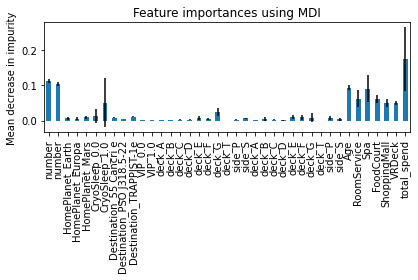

In [49]:
importances = clf.feature_importances_

forest_importances = pd.Series(importances, index=final_test_feature_df.columns)
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [50]:
important_features = ['Age','RoomService','Spa','FoodCourt','ShoppingMall','VRDeck'] # Adding Cryosleep makes the result worse

X_train, X_test, y_train, y_test = train_test_split(final_feature_df[important_features], train_df.Transported, test_size=0.2)

clf.fit(X_train, y_train)

# performing predictions on the test dataset
y_pred = clf.predict(X_test)
 
# metrics are used to find accuracy or error
from sklearn import metrics 
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL:  0.777458309373203


In [51]:
# Reducing features and resubmitting
y_sub = clf.predict(final_test_feature_df[important_features])

pd.merge(test_df['PassengerId'],pd.DataFrame(y_sub,columns=['Transported']),left_index=True,right_index=True)\
            .to_csv('important_features_submission.csv',index=False)

# Score: 0.49988

In [52]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 5,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Applying Grid Search

In [53]:
parameters = {'n_estimators':(500,1000), 'max_depth':[5,10],'criterion':['gini','entropy','log_loss'],
                         'min_samples_split':[12,25,50]}
algo = RandomForestClassifier()

clf_gs = GridSearchCV(algo, parameters,verbose=3)

clf_gs.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END criterion=gini, max_depth=5, min_samples_split=12, n_estimators=500;, score=0.774 total time=   1.5s
[CV 2/5] END criterion=gini, max_depth=5, min_samples_split=12, n_estimators=500;, score=0.787 total time=   1.6s
[CV 3/5] END criterion=gini, max_depth=5, min_samples_split=12, n_estimators=500;, score=0.787 total time=   1.6s
[CV 4/5] END criterion=gini, max_depth=5, min_samples_split=12, n_estimators=500;, score=0.796 total time=   1.6s
[CV 5/5] END criterion=gini, max_depth=5, min_samples_split=12, n_estimators=500;, score=0.779 total time=   1.5s
[CV 1/5] END criterion=gini, max_depth=5, min_samples_split=12, n_estimators=1000;, score=0.773 total time=   3.3s
[CV 2/5] END criterion=gini, max_depth=5, min_samples_split=12, n_estimators=1000;, score=0.787 total time=   3.4s
[CV 3/5] END criterion=gini, max_depth=5, min_samples_split=12, n_estimators=1000;, score=0.786 total time=   3.3s
[CV 4/5] END criterion=

KeyboardInterrupt: 

In [54]:
clf_gs.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [49]:
clf_gs.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_split': 50,
 'n_estimators': 500}

In [55]:
clf = RandomForestClassifier(criterion='entropy',max_depth=10,min_samples_split=50,n_estimators = 500)

X_train, X_test, y_train, y_test = train_test_split(final_feature_df, train_df.Transported, test_size=0.2)

clf.fit(X_train, y_train)

# performing predictions on the test dataset
y_pred = clf.predict(X_test)
# metrics are used to find accuracy or error
from sklearn import metrics 
print()
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL:  0.8021851638872916


In [56]:
# Re-training model with all train data
clf.fit(final_feature_df,train_df.Transported)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=50,
                       n_estimators=500)

In [83]:
y_sub = pd.Series(y_sub).replace({1:'True',0:'False'}).values

In [84]:
pd.merge(test_df['PassengerId'],pd.DataFrame(y_sub,columns=['Transported']),left_index=True,right_index=True)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False


In [85]:
y_sub = clf.predict(final_test_feature_df)
y_sub = pd.Series(y_sub).replace({1:'True',0:'False'}).values

pd.merge(test_df['PassengerId'],pd.DataFrame(y_sub,columns=['Transported']),left_index=True,right_index=True)\
            .to_csv('grid_search_submission.csv',index=False)